In [1]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor , HistGradientBoostingClassifier


# Import required modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

# Create output directory for all saved files
from datetime import datetime
import pickle
import json

# Create timestamp for this run
output_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"../data/{output_timestamp}_attribution_model"
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory created: {output_dir}")
print(f"All files will be saved to: {os.path.abspath(output_dir)}")

# Helper function to create output path
def get_output_path(filename):
    return os.path.join(output_dir, filename)

/Users/bp/miniforge3/envs/data-analytics/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Output directory created: ../data/20250723_161150_attribution_model
All files will be saved to: /Users/bp/workspace/msh/data-analytics/notebooks/data/20250723_161150_attribution_model


V2. Focus only on MA

### Load raw data

In [2]:
query = f"select * from attribution_prediction_model;"
df = cb_utils.sql_query_to_df(query, use_cache=True, source='msh_member_doc')

Pulling query from db


In [3]:
df.head()

,patient_id,is_attributed_in_prediction_year,patient_age,gender,primary_referring_partner_id,primary_rpo_id,patient_payer_id,contract_type_key,current_primary_rpl_type,current_primary_rpl_is_nursing_home,current_primary_rpl_is_urgent_care,current_primary_rpo_org_type,cms_plan_type,ma_product_key,cca_eligible_appts,provider_appts,total_appts,appt_count_group,distinct_rpls,distinct_rpos,distinct_physicians,appts_with_primary_rpl,appts_with_primary_rpo,nursing_home_appts,distinct_appt_months,max_appt_month,appts_allergy_immunology,appts_anesthesiology,appts_clinical_neuropsychologist,appts_clinical_nurse_specialist,appts_colon_rectal_surgery,appts_dermatology,appts_emergency_medicine,appts_family_medicine,appts_general_practice,appts_hospitalist,appts_internal_medicine,appts_licensed_practical_nurse,appts_neuromusculoskeletal_sports_medicine,appts_nurse_practitioner,appts_obstetrics_gynecology,appts_ophthalmology,appts_otolaryngology,appts_pathology,appts_pediatrics,appts_physical_therapist,appts_physician_assistant,appts_podiatrist,appts_psychiatry_neurology,appts_psychologist,appts_radiology,appts_registered_nurse,appts_surgery,appts_urology,attributed_in_year_n
0,674631,False,67.0,Female,1476,1101,38,ma,multi_specialty_provider_group,False,False,Independent Primary Care,Local PPO,individual,0,0,0,no_appts,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1074674,True,69.0,Male,2836,1633,81,om,pcp,False,False,CAH-RHC,None,None,2,2,2,two_appts,1,1,1,2,2,0,2,5.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,1405573,False,78.0,Male,1940,1567,47,ma,fqhc,False,False,Independent FQHC,HMOPOS,csnp,2,2,2,two_appts,1,1,2,2,2,0,2,12.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,1440936,False,83.0,Female,4084,12,44,ma,nursing_home,True,False,Independent RHC,HMOPOS,individual,0,0,5,three_to_five_appts,2,2,3,3,3,3,3,11.0,0,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,350881,False,62.0,Male,828,36,2,ma,health_system,False,False,CAH-RHC,HMOPOS,individual,3,3,3,three_to_five_appts,2,1,2,2,3,0,3,7.0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [4]:
df = df.loc[df['contract_type_key'] == 'ma']

In [5]:
df.head()

,patient_id,is_attributed_in_prediction_year,patient_age,gender,primary_referring_partner_id,primary_rpo_id,patient_payer_id,contract_type_key,current_primary_rpl_type,current_primary_rpl_is_nursing_home,current_primary_rpl_is_urgent_care,current_primary_rpo_org_type,cms_plan_type,ma_product_key,cca_eligible_appts,provider_appts,total_appts,appt_count_group,distinct_rpls,distinct_rpos,distinct_physicians,appts_with_primary_rpl,appts_with_primary_rpo,nursing_home_appts,distinct_appt_months,max_appt_month,appts_allergy_immunology,appts_anesthesiology,appts_clinical_neuropsychologist,appts_clinical_nurse_specialist,appts_colon_rectal_surgery,appts_dermatology,appts_emergency_medicine,appts_family_medicine,appts_general_practice,appts_hospitalist,appts_internal_medicine,appts_licensed_practical_nurse,appts_neuromusculoskeletal_sports_medicine,appts_nurse_practitioner,appts_obstetrics_gynecology,appts_ophthalmology,appts_otolaryngology,appts_pathology,appts_pediatrics,appts_physical_therapist,appts_physician_assistant,appts_podiatrist,appts_psychiatry_neurology,appts_psychologist,appts_radiology,appts_registered_nurse,appts_surgery,appts_urology,attributed_in_year_n
0,674631,False,67.0,Female,1476,1101,38,ma,multi_specialty_provider_group,False,False,Independent Primary Care,Local PPO,individual,0,0,0,no_appts,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,1405573,False,78.0,Male,1940,1567,47,ma,fqhc,False,False,Independent FQHC,HMOPOS,csnp,2,2,2,two_appts,1,1,2,2,2,0,2,12.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,1440936,False,83.0,Female,4084,12,44,ma,nursing_home,True,False,Independent RHC,HMOPOS,individual,0,0,5,three_to_five_appts,2,2,3,3,3,3,3,11.0,0,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,350881,False,62.0,Male,828,36,2,ma,health_system,False,False,CAH-RHC,HMOPOS,individual,3,3,3,three_to_five_appts,2,1,2,2,3,0,3,7.0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
6,1305064,False,85.0,Female,1634,12,44,ma,nursing_home,True,False,Independent RHC,Local PPO,individual,0,0,7,greater_than_6_appts,1,1,1,7,7,7,1,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [6]:
df.shape

(210617, 55)

In [7]:
df.patient_id.nunique()

210617

In [8]:
df.drop(columns=['contract_type_key', 'current_primary_rpl_type'], inplace=True)

In [9]:

df.head()

,patient_id,is_attributed_in_prediction_year,patient_age,gender,primary_referring_partner_id,primary_rpo_id,patient_payer_id,current_primary_rpl_is_nursing_home,current_primary_rpl_is_urgent_care,current_primary_rpo_org_type,cms_plan_type,ma_product_key,cca_eligible_appts,provider_appts,total_appts,appt_count_group,distinct_rpls,distinct_rpos,distinct_physicians,appts_with_primary_rpl,appts_with_primary_rpo,nursing_home_appts,distinct_appt_months,max_appt_month,appts_allergy_immunology,appts_anesthesiology,appts_clinical_neuropsychologist,appts_clinical_nurse_specialist,appts_colon_rectal_surgery,appts_dermatology,appts_emergency_medicine,appts_family_medicine,appts_general_practice,appts_hospitalist,appts_internal_medicine,appts_licensed_practical_nurse,appts_neuromusculoskeletal_sports_medicine,appts_nurse_practitioner,appts_obstetrics_gynecology,appts_ophthalmology,appts_otolaryngology,appts_pathology,appts_pediatrics,appts_physical_therapist,appts_physician_assistant,appts_podiatrist,appts_psychiatry_neurology,appts_psychologist,appts_radiology,appts_registered_nurse,appts_surgery,appts_urology,attributed_in_year_n
0,674631,False,67.0,Female,1476,1101,38,False,False,Independent Primary Care,Local PPO,individual,0,0,0,no_appts,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,1405573,False,78.0,Male,1940,1567,47,False,False,Independent FQHC,HMOPOS,csnp,2,2,2,two_appts,1,1,2,2,2,0,2,12.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,1440936,False,83.0,Female,4084,12,44,True,False,Independent RHC,HMOPOS,individual,0,0,5,three_to_five_appts,2,2,3,3,3,3,3,11.0,0,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,350881,False,62.0,Male,828,36,2,False,False,CAH-RHC,HMOPOS,individual,3,3,3,three_to_five_appts,2,1,2,2,3,0,3,7.0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
6,1305064,False,85.0,Female,1634,12,44,True,False,Independent RHC,Local PPO,individual,0,0,7,greater_than_6_appts,1,1,1,7,7,7,1,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [10]:
# Data preprocessing
print("Dataset shape:", df.shape)
print("Target distribution:")
print(df['is_attributed_in_prediction_year'].value_counts())
print(f"Attribution rate: {df['is_attributed_in_prediction_year'].mean():.3f}")

# Check for missing values
print("\nMissing values per column:")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Check data types
print("\nData types:")
print(df.dtypes.value_counts())


Dataset shape: (210617, 53)
Target distribution:
True     138625
False     71992
Name: is_attributed_in_prediction_year, dtype: int64
Attribution rate: 0.658

Missing values per column:
cms_plan_type     30596
max_appt_month    46885
dtype: int64

Data types:
int64      42
object      5
bool        4
float64     2
dtype: int64


In [23]:
# Prepare features and target
# Remove patient_id as it's just an identifier
features = df.drop(['patient_id', 'primary_rpo_id', 'primary_referring_partner_id', 'is_attributed_in_prediction_year', 'attributed_in_year_n'], axis=1)
target = df['is_attributed_in_prediction_year']

print("Features shape:", features.shape)
print("Features columns:")
print(features.columns.tolist())

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'bool']).columns.tolist()

# Add all columns ending with '_id' as categorical (even if they're numeric)
id_columns = [col for col in features.columns if col.endswith('_id')]
categorical_cols.extend(id_columns)
# Remove duplicates while preserving order
categorical_cols = list(dict.fromkeys(categorical_cols))

# Numerical columns are all remaining columns
numerical_cols = [col for col in features.columns if col not in categorical_cols]

print(f"\nCategorical columns ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\nNumerical columns ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nID columns identified as categorical: {id_columns}")


Features shape: (210617, 48)
Features columns:
['patient_age', 'gender', 'patient_payer_id', 'current_primary_rpl_is_nursing_home', 'current_primary_rpl_is_urgent_care', 'current_primary_rpo_org_type', 'cms_plan_type', 'ma_product_key', 'cca_eligible_appts', 'provider_appts', 'total_appts', 'appt_count_group', 'distinct_rpls', 'distinct_rpos', 'distinct_physicians', 'appts_with_primary_rpl', 'appts_with_primary_rpo', 'nursing_home_appts', 'distinct_appt_months', 'max_appt_month', 'appts_allergy_immunology', 'appts_anesthesiology', 'appts_clinical_neuropsychologist', 'appts_clinical_nurse_specialist', 'appts_colon_rectal_surgery', 'appts_dermatology', 'appts_emergency_medicine', 'appts_family_medicine', 'appts_general_practice', 'appts_hospitalist', 'appts_internal_medicine', 'appts_licensed_practical_nurse', 'appts_neuromusculoskeletal_sports_medicine', 'appts_nurse_practitioner', 'appts_obstetrics_gynecology', 'appts_ophthalmology', 'appts_otolaryngology', 'appts_pathology', 'appts_pe

In [24]:
# Prepare features for HistGradientBoostingClassifier
# HistGradientBoostingClassifier expects categorical features as integers (0, 1, 2, etc.)
from sklearn.preprocessing import LabelEncoder

features_processed = features.copy()

# Store label encoders for later use if needed
label_encoders = {}

# Encode categorical features as integers
for col in categorical_cols:
    le = LabelEncoder()
    # Handle missing values by filling with a placeholder
    features_processed[col] = features_processed[col].fillna('missing')
    features_processed[col] = le.fit_transform(features_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique categories")

# Get indices of categorical columns
categorical_feature_indices = [features_processed.columns.get_loc(col) for col in categorical_cols]

print(f"\nCategorical columns and their indices:")
for i, col in enumerate(categorical_cols):
    idx = categorical_feature_indices[i]
    print(f"{col}: index {idx}")

print(f"\nCategorical feature indices: {categorical_feature_indices}")
print(f"Total features: {len(features_processed.columns)}")
print(f"Categorical features: {len(categorical_feature_indices)}")
print(f"Numerical features: {len(features_processed.columns) - len(categorical_feature_indices)}")


Encoded gender: 3 unique categories
Encoded current_primary_rpl_is_nursing_home: 2 unique categories
Encoded current_primary_rpl_is_urgent_care: 2 unique categories
Encoded current_primary_rpo_org_type: 11 unique categories
Encoded cms_plan_type: 8 unique categories
Encoded ma_product_key: 5 unique categories
Encoded appt_count_group: 5 unique categories
Encoded patient_payer_id: 13 unique categories

Categorical columns and their indices:
gender: index 1
current_primary_rpl_is_nursing_home: index 3
current_primary_rpl_is_urgent_care: index 4
current_primary_rpo_org_type: index 5
cms_plan_type: index 6
ma_product_key: index 7
appt_count_group: index 11
patient_payer_id: index 2

Categorical feature indices: [1, 3, 4, 5, 6, 7, 11, 2]
Total features: 48
Categorical features: 8
Numerical features: 40


In [25]:
# Verify the processed features
print("Data types after processing:")
print(features_processed.dtypes.value_counts())
print("\nSample of processed features:")
print(features_processed.head())

# Check for any remaining missing values
print(f"\nMissing values after processing:")
missing_after = features_processed.isnull().sum()
print(missing_after[missing_after > 0])

# Verify categorical columns are now integer encoded
print(f"\nSample values for categorical columns:")
for col in categorical_cols[:3]:  # Show first 3 categorical columns
    print(f"{col}: {features_processed[col].unique()[:10]}")  # First 10 unique values

Data types after processing:
int64      46
float64     2
dtype: int64

Sample of processed features:
   patient_age  gender  patient_payer_id  current_primary_rpl_is_nursing_home  \
0         67.0       0                 2                                    0   
2         78.0       1                 6                                    0   
3         83.0       0                 5                                    1   
4         62.0       1                 1                                    0   
6         85.0       0                 5                                    1   

   current_primary_rpl_is_urgent_care  current_primary_rpo_org_type  \
0                                   0                             6   
2                                   0                             4   
3                                   0                             7   
4                                   0                             1   
6                                   0                    

In [26]:
# Split the data 80-20 for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features_processed, 
    target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {y_train.mean():.3f}")
print(f"Test target distribution: {y_test.mean():.3f}")


Training set shape: (168493, 48)
Test set shape: (42124, 48)
Training target distribution: 0.658
Test target distribution: 0.658


In [27]:
# Train HistGradientBoostingClassifier
print("Training HistGradientBoostingClassifier...")
print(f"Data shape: {X_train.shape}")
print(f"Data types: {X_train.dtypes.value_counts()}")
print(f"Categorical feature indices: {categorical_feature_indices}")

start_time = time.time()

# Initialize the model with explicit categorical feature indices
# Note: categorical_features expects integer indices of columns that are categorical
hgb_model = HistGradientBoostingClassifier(
    random_state=42,
    categorical_features=categorical_feature_indices,  # Integer indices of categorical columns
    verbose=1  # Show progress
)

# Train the model
hgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")


Training HistGradientBoostingClassifier...
Data shape: (168493, 48)
Data types: int64      46
float64     2
dtype: int64
Categorical feature indices: [1, 3, 4, 5, 6, 7, 11, 2]
Binning 0.058 GB of training data: 0.268 s
Binning 0.006 GB of validation data: 0.009 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.60212, val loss: 0.60224, in 0.049s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.57093, val loss: 0.57113, in 0.045s
[3/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.54593, val loss: 0.54627, in 0.045s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.52524, val loss: 0.52558, in 0.052s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.50800, val loss: 0.50849, in 0.051s
[6/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.49343, val loss: 0.49407, in 0.044s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.48081, val loss: 0.48165, in 0.042s
[8/100] 1 tree, 31 leaves, max depth = 12, train los

In [28]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("Evaluating model performance...")

# Make predictions
y_train_pred = hgb_model.predict(X_train)
y_test_pred = hgb_model.predict(X_test)

# Get prediction probabilities for ROC AUC
y_train_proba = hgb_model.predict_proba(X_train)[:, 1]
y_test_proba = hgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_metrics = {
    'accuracy': accuracy_score(y_train, y_train_pred),
    'precision': precision_score(y_train, y_train_pred),
    'recall': recall_score(y_train, y_train_pred),
    'f1': f1_score(y_train, y_train_pred),
    'roc_auc': roc_auc_score(y_train, y_train_proba)
}

test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_proba)
}

# Print results
print("\n" + "="*60)
print("MODEL PERFORMANCE RESULTS")
print("="*60)

print("\nTRAINING SET METRICS:")
for metric, value in train_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("\nTEST SET METRICS:")
for metric, value in test_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("\nDETAILED CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred))


Evaluating model performance...



MODEL PERFORMANCE RESULTS

TRAINING SET METRICS:
ACCURACY: 0.8297
PRECISION: 0.8181
RECALL: 0.9531
F1: 0.8805
ROC_AUC: 0.8789

TEST SET METRICS:
ACCURACY: 0.8263
PRECISION: 0.8153
RECALL: 0.9517
F1: 0.8783
ROC_AUC: 0.8718

DETAILED CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

       False       0.86      0.58      0.70     14399
        True       0.82      0.95      0.88     27725

    accuracy                           0.83     42124
   macro avg       0.84      0.77      0.79     42124
weighted avg       0.83      0.83      0.82     42124



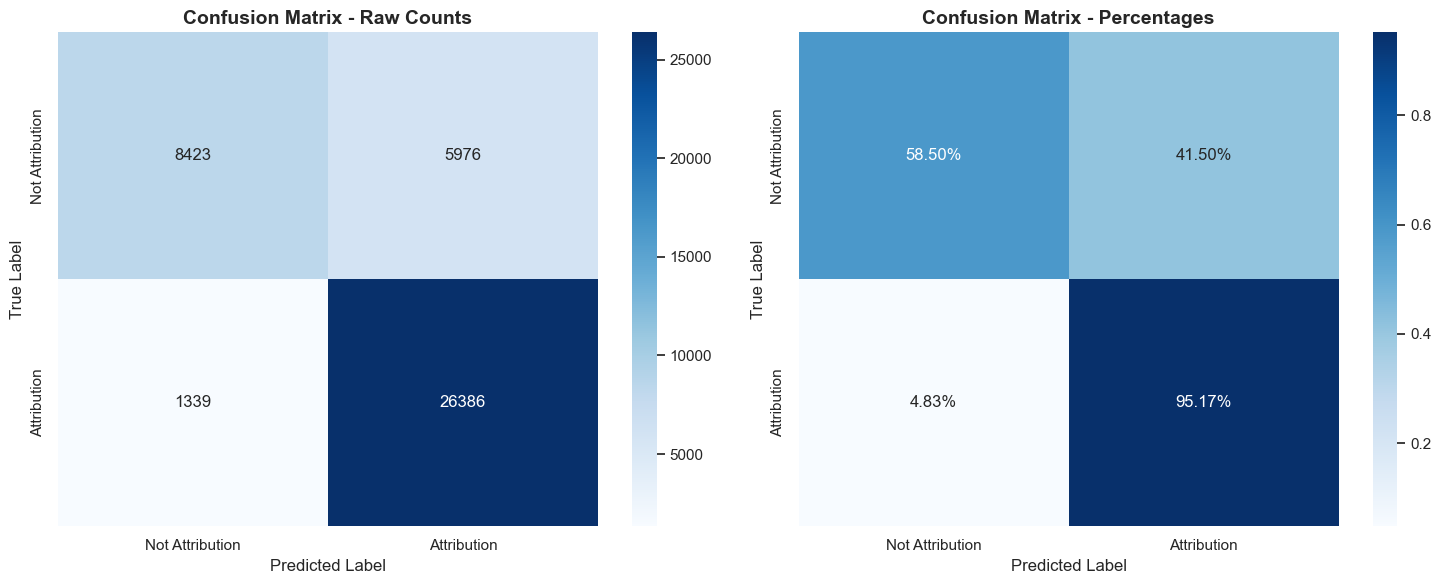


CONFUSION MATRIX ANALYSIS

RAW COUNTS:
True Negatives (TN):  8,423
False Positives (FP): 5,976
False Negatives (FN): 1,339
True Positives (TP):  26,386

PERCENTAGES (of actual class):
True Negatives (TN):  58.50%
False Positives (FP): 41.50%
False Negatives (FN): 4.83%
True Positives (TP):  95.17%

SUMMARY:
Total test samples: 42,124
Correctly classified: 34,809 (82.63%)
Incorrectly classified: 7,315 (17.37%)

CLASS-SPECIFIC ACCURACY:
Not Attribution class: 58.50%
Attribution class: 95.17%


In [29]:
# Display confusion matrices for test set
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrices
cm_counts = confusion_matrix(y_test, y_test_pred)
cm_percentages = confusion_matrix(y_test, y_test_pred, normalize='true')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define class labels for better readability
class_labels = ['Not Attribution', 'Attribution']

# 1. Confusion Matrix with Raw Counts
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax1)
ax1.set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)


# 2. Confusion Matrix with Percentages
sns.heatmap(cm_percentages, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
ax2.set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print additional confusion matrix metrics
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)

print(f"\nRAW COUNTS:")
print(f"True Negatives (TN):  {cm_counts[0, 0]:,}")
print(f"False Positives (FP): {cm_counts[0, 1]:,}")
print(f"False Negatives (FN): {cm_counts[1, 0]:,}")
print(f"True Positives (TP):  {cm_counts[1, 1]:,}")

print(f"\nPERCENTAGES (of actual class):")
print(f"True Negatives (TN):  {cm_percentages[0, 0]:.2%}")
print(f"False Positives (FP): {cm_percentages[0, 1]:.2%}")
print(f"False Negatives (FN): {cm_percentages[1, 0]:.2%}")
print(f"True Positives (TP):  {cm_percentages[1, 1]:.2%}")

# Calculate additional insights
total_samples = cm_counts.sum()
total_correct = cm_counts[0, 0] + cm_counts[1, 1]
total_incorrect = cm_counts[0, 1] + cm_counts[1, 0]

print(f"\nSUMMARY:")
print(f"Total test samples: {total_samples:,}")
print(f"Correctly classified: {total_correct:,} ({total_correct/total_samples:.2%})")
print(f"Incorrectly classified: {total_incorrect:,} ({total_incorrect/total_samples:.2%})")

# Class-specific accuracy
print(f"\nCLASS-SPECIFIC ACCURACY:")
print(f"Not Attribution class: {cm_counts[0, 0] / (cm_counts[0, 0] + cm_counts[0, 1]):.2%}")
print(f"Attribution class: {cm_counts[1, 1] / (cm_counts[1, 0] + cm_counts[1, 1]):.2%}")


In [30]:
# Permutation Feature Importance Analysis
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

print("Calculating permutation feature importance...")
print("This may take a few minutes...")

# Calculate permutation importance on test set (more reliable than training set)
perm_importance = permutation_importance(
    hgb_model, 
    X_test, 
    y_test, 
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring='roc_auc'  # Use ROC AUC as the scoring metric
)

# Create a DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"\nPermutation Feature Importance completed!")
print(f"Total features analyzed: {len(feature_importance_df)}")
print(f"\nTop 20 Most Important Features:")
print("=" * 60)
for idx, row in feature_importance_df.head(20).iterrows():
    print(f"{row['feature']:40} {row['importance_mean']:8.4f} ± {row['importance_std']:6.4f}")

# Also show the least important features
print(f"\nBottom 10 Least Important Features:")
print("=" * 60)
for idx, row in feature_importance_df.tail(10).iterrows():
    print(f"{row['feature']:40} {row['importance_mean']:8.4f} ± {row['importance_std']:6.4f}")

# Summary statistics
print(f"\nFeature Importance Summary:")
print(f"Mean importance: {feature_importance_df['importance_mean'].mean():.4f}")
print(f"Std importance: {feature_importance_df['importance_mean'].std():.4f}")
print(f"Max importance: {feature_importance_df['importance_mean'].max():.4f}")
print(f"Min importance: {feature_importance_df['importance_mean'].min():.4f}")
print(f"Features with positive importance: {(feature_importance_df['importance_mean'] > 0).sum()}")
print(f"Features with negative importance: {(feature_importance_df['importance_mean'] < 0).sum()}")


Calculating permutation feature importance...
This may take a few minutes...

Permutation Feature Importance completed!
Total features analyzed: 48

Top 20 Most Important Features:
cms_plan_type                              0.0674 ± 0.0015
ma_product_key                             0.0417 ± 0.0010
patient_payer_id                           0.0393 ± 0.0010
current_primary_rpo_org_type               0.0234 ± 0.0007
max_appt_month                             0.0186 ± 0.0010
cca_eligible_appts                         0.0121 ± 0.0006
appts_with_primary_rpo                     0.0082 ± 0.0005
appts_family_medicine                      0.0058 ± 0.0005
distinct_appt_months                       0.0041 ± 0.0003
current_primary_rpl_is_nursing_home        0.0032 ± 0.0003
provider_appts                             0.0027 ± 0.0003
appts_with_primary_rpl                     0.0024 ± 0.0002
patient_age                                0.0023 ± 0.0002
appts_internal_medicine                    0.0023 ± 

/var/folders/w0/dn9609j53qd4nphdjz72p3kr0000gn/T/ipykernel_59376/3114813140.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, ax=ax3, label='Importance')


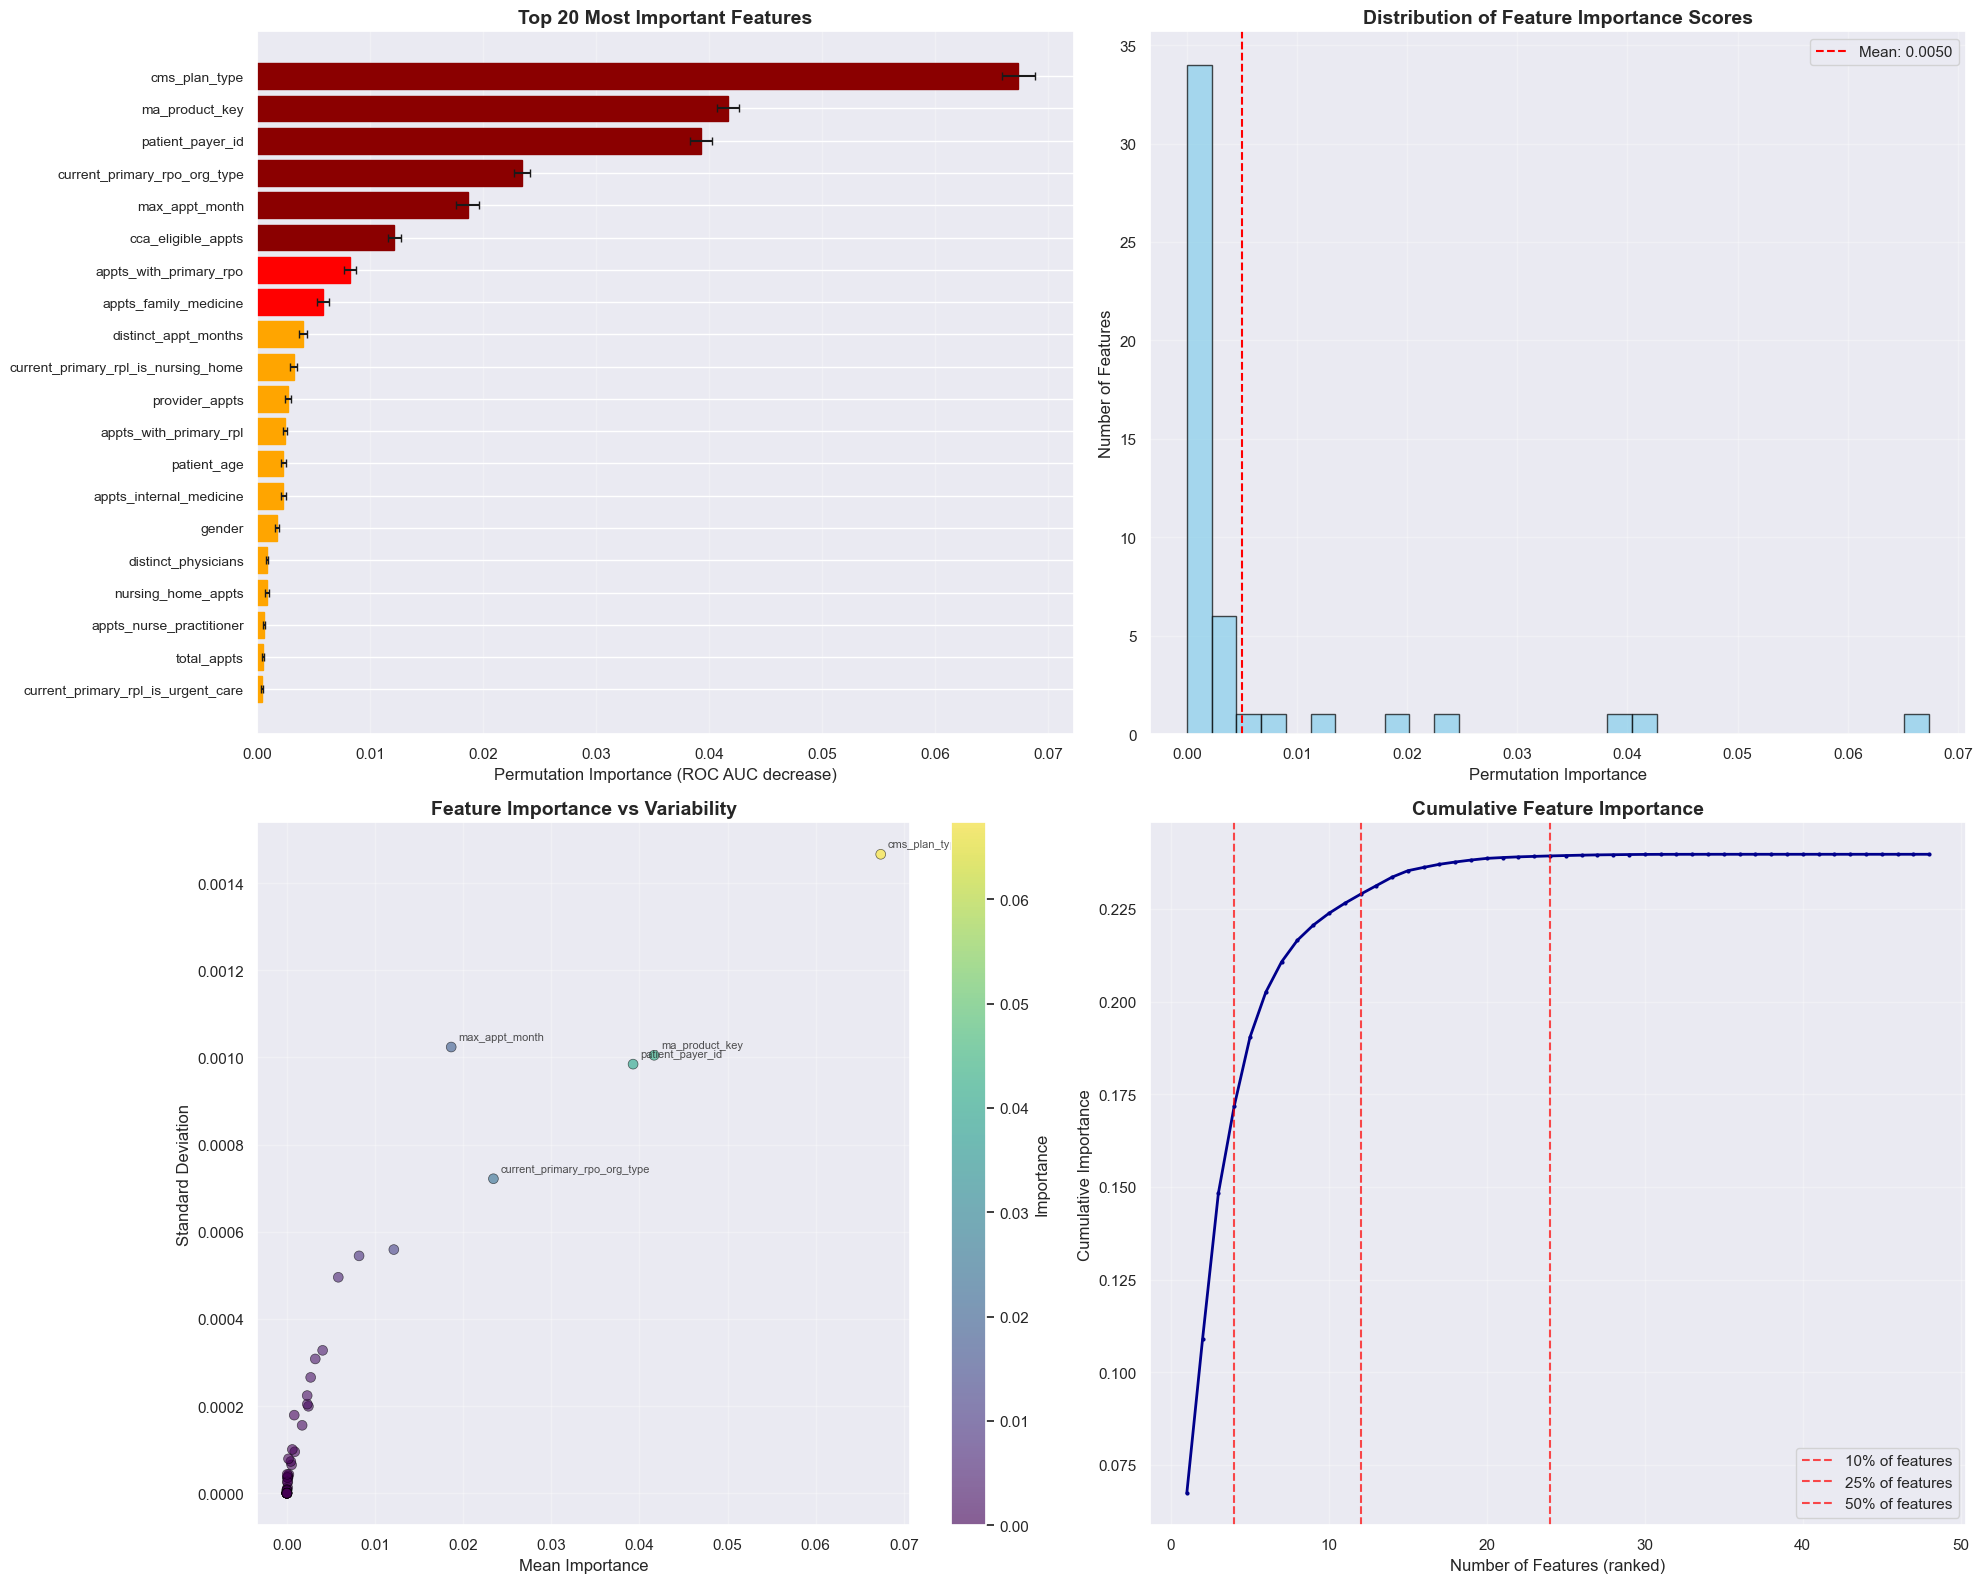


FEATURE IMPORTANCE INSIGHTS

High Impact Features (importance > 0.01): 6
  • cms_plan_type: 0.0674
  • ma_product_key: 0.0417
  • patient_payer_id: 0.0393
  • current_primary_rpo_org_type: 0.0234
  • max_appt_month: 0.0186
  • cca_eligible_appts: 0.0121

Feature Type Analysis:
Appointment-related features: 30 (avg importance: 0.0007)
Demographic features: 2 (avg importance: 0.0020)

Most Stable Important Features (high importance, low variability):
  • cms_plan_type: 0.0674 (stability: 46.0)
  • ma_product_key: 0.0417 (stability: 41.5)
  • patient_payer_id: 0.0393 (stability: 39.9)
  • current_primary_rpo_org_type: 0.0234 (stability: 32.5)
  • cca_eligible_appts: 0.0121 (stability: 21.7)
  • max_appt_month: 0.0186 (stability: 18.2)
  • appts_with_primary_rpo: 0.0082 (stability: 15.0)
  • appts_family_medicine: 0.0058 (stability: 11.8)


In [31]:
# Visualize Feature Importance Results
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Top 20 features bar plot
top_20 = feature_importance_df.head(20)
ax1 = axes[0, 0]
bars = ax1.barh(range(len(top_20)), top_20['importance_mean'], 
                xerr=top_20['importance_std'], capsize=3)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'], fontsize=10)
ax1.set_xlabel('Permutation Importance (ROC AUC decrease)', fontsize=12)
ax1.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Color bars based on importance level
colors = ['darkred' if x > 0.01 else 'red' if x > 0.005 else 'orange' for x in top_20['importance_mean']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

# 2. All features distribution
ax2 = axes[0, 1]
ax2.hist(feature_importance_df['importance_mean'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(feature_importance_df['importance_mean'].mean(), color='red', linestyle='--', 
            label=f'Mean: {feature_importance_df["importance_mean"].mean():.4f}')
ax2.set_xlabel('Permutation Importance', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Feature importance vs standard deviation
ax3 = axes[1, 0]
scatter = ax3.scatter(feature_importance_df['importance_mean'], feature_importance_df['importance_std'], 
                     alpha=0.6, s=50, c=feature_importance_df['importance_mean'], 
                     cmap='viridis', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Mean Importance', fontsize=12)
ax3.set_ylabel('Standard Deviation', fontsize=12)
ax3.set_title('Feature Importance vs Variability', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Importance')

# Add labels for top features
for idx, row in feature_importance_df.head(5).iterrows():
    ax3.annotate(row['feature'], (row['importance_mean'], row['importance_std']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 4. Cumulative importance plot
ax4 = axes[1, 1]
cumulative_importance = feature_importance_df['importance_mean'].cumsum()
ax4.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', markersize=2, linewidth=2, color='darkblue')
ax4.set_xlabel('Number of Features (ranked)', fontsize=12)
ax4.set_ylabel('Cumulative Importance', fontsize=12)
ax4.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

# Add vertical lines at key percentiles
percentiles = [10, 25, 50]
for p in percentiles:
    pos = int(len(cumulative_importance) * p / 100)
    ax4.axvline(pos, color='red', linestyle='--', alpha=0.7, 
                label=f'{p}% of features')

ax4.legend()

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*80)
print("FEATURE IMPORTANCE INSIGHTS")
print("="*80)

# Top performing features
high_importance = feature_importance_df[feature_importance_df['importance_mean'] > 0.01]
print(f"\nHigh Impact Features (importance > 0.01): {len(high_importance)}")
for idx, row in high_importance.iterrows():
    print(f"  • {row['feature']}: {row['importance_mean']:.4f}")

# Feature analysis by type
appointment_features = feature_importance_df[feature_importance_df['feature'].str.contains('appts_')]
demographic_features = feature_importance_df[feature_importance_df['feature'].isin(['patient_age', 'gender'])]

print(f"\nFeature Type Analysis:")
print(f"Appointment-related features: {len(appointment_features)} (avg importance: {appointment_features['importance_mean'].mean():.4f})")
print(f"Demographic features: {len(demographic_features)} (avg importance: {demographic_features['importance_mean'].mean():.4f})")

# Show most stable features (low std relative to mean)
feature_importance_df['stability_ratio'] = feature_importance_df['importance_mean'] / (feature_importance_df['importance_std'] + 1e-10)
stable_features = feature_importance_df[feature_importance_df['importance_mean'] > 0.005].nlargest(10, 'stability_ratio')
print(f"\nMost Stable Important Features (high importance, low variability):")
for idx, row in stable_features.iterrows():
    print(f"  • {row['feature']}: {row['importance_mean']:.4f} (stability: {row['stability_ratio']:.1f})")


In [32]:
# Create a comprehensive feature importance table
feature_importance_table = feature_importance_df.copy()
feature_importance_table['rank'] = range(1, len(feature_importance_table) + 1)

# Calculate relative importance (as percentage of total)
total_importance = feature_importance_table['importance_mean'].sum()
feature_importance_table['relative_importance_pct'] = (feature_importance_table['importance_mean'] / total_importance) * 100

# Format the table nicely
display_table = feature_importance_table[['rank', 'feature', 'importance_mean', 'importance_std', 'relative_importance_pct']].copy()
display_table.columns = ['Rank', 'Feature', 'Importance', 'Std Dev', 'Relative %']

print("COMPLETE FEATURE IMPORTANCE RANKING")
print("="*100)
print(display_table.to_string(index=False, float_format='%.4f'))

# Save the results to a CSV file for future reference
output_file = get_output_path('feature_importance_results.csv')
feature_importance_table.to_csv(output_file, index=False)
print(f"\nFeature importance results saved to: {output_file}")

# Final recommendations
print("\n" + "="*80)
print("RECOMMENDATIONS FOR MODEL IMPROVEMENT")
print("="*80)

top_features = feature_importance_table.head(10)

# Features that might be removed
low_importance = feature_importance_table[feature_importance_table['importance_mean'] < 0.001]
print(f"\nFeatures with very low importance (< 0.001) that could be considered for removal: {len(low_importance)}")
if len(low_importance) > 0:
    print("Consider removing these features:")
    for idx, row in low_importance.tail(10).iterrows():
        print(f"  • {row['feature']}: {row['importance_mean']:.4f}")

print(f"\nModel could potentially be simplified by focusing on the top {len(feature_importance_table[feature_importance_table['importance_mean'] > 0.005])} features with importance > 0.005")


COMPLETE FEATURE IMPORTANCE RANKING
 Rank                                    Feature  Importance  Std Dev  Relative %
    1                              cms_plan_type      0.0674   0.0015     28.1017
    2                             ma_product_key      0.0417   0.0010     17.3798
    3                           patient_payer_id      0.0393   0.0010     16.3827
    4               current_primary_rpo_org_type      0.0234   0.0007      9.7737
    5                             max_appt_month      0.0186   0.0010      7.7761
    6                         cca_eligible_appts      0.0121   0.0006      5.0606
    7                     appts_with_primary_rpo      0.0082   0.0005      3.4162
    8                      appts_family_medicine      0.0058   0.0005      2.4327
    9                       distinct_appt_months      0.0041   0.0003      1.6914
   10        current_primary_rpl_is_nursing_home      0.0032   0.0003      1.3436
   11                             provider_appts      0.0027  

In [33]:
# Extract top 20 features from feature importance analysis
top_20_features = feature_importance_df.head(20)['feature'].tolist()

print("Top 20 features selected for hyperparameter tuning:")
print("="*60)
for i, feature in enumerate(top_20_features, 1):
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance_mean'].iloc[0]
    print(f"{i:2d}. {feature:35} {importance:.4f}")

# Create reduced datasets with only top 20 features
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

print(f"\nReduced dataset shapes:")
print(f"Training set: {X_train_top20.shape}")
print(f"Test set: {X_test_top20.shape}")

# Update categorical feature indices for the reduced dataset
categorical_features_top20 = []
for i, feature in enumerate(top_20_features):
    if feature in categorical_cols:
        categorical_features_top20.append(i)

print(f"\nCategorical features in top 20: {len(categorical_features_top20)}")
print(f"Categorical feature indices: {categorical_features_top20}")
for idx in categorical_features_top20:
    print(f"  Index {idx}: {top_20_features[idx]}")


Top 20 features selected for hyperparameter tuning:
 1. cms_plan_type                       0.0674
 2. ma_product_key                      0.0417
 3. patient_payer_id                    0.0393
 4. current_primary_rpo_org_type        0.0234
 5. max_appt_month                      0.0186
 6. cca_eligible_appts                  0.0121
 7. appts_with_primary_rpo              0.0082
 8. appts_family_medicine               0.0058
 9. distinct_appt_months                0.0041
10. current_primary_rpl_is_nursing_home 0.0032
11. provider_appts                      0.0027
12. appts_with_primary_rpl              0.0024
13. patient_age                         0.0023
14. appts_internal_medicine             0.0023
15. gender                              0.0017
16. distinct_physicians                 0.0009
17. nursing_home_appts                  0.0008
18. appts_nurse_practitioner            0.0006
19. total_appts                         0.0005
20. current_primary_rpl_is_urgent_care  0.0004

Reduced

In [34]:
# Hyperparameter tuning for HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np

print("Setting up hyperparameter tuning...")
print("Using RandomizedSearchCV for efficiency with large dataset")

# Define hyperparameter search space for HistGradientBoostingClassifier
param_distributions = {
    'max_iter': [100, 200, 300],  # Number of boosting iterations
    'learning_rate': [0.05, 0.1, 0.15, 0.2],  # Step size shrinkage
    'max_depth': [3, 6, 10, None],  # Maximum depth of trees
    'min_samples_leaf': [20, 50, 100],  # Minimum samples in leaf node
    'max_bins': [100, 200, 255],  # Maximum number of bins for numerical features
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],  # L2 regularization parameter
    'early_stopping': [True],  # Enable early stopping
    'validation_fraction': [0.1],  # Fraction of data to use for validation
    'n_iter_no_change': [10],  # Number of iterations without improvement before stopping
    'tol': [1e-7]  # Tolerance for early stopping
}

print("\nHyperparameter search space:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

# Create stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the base estimator
base_estimator = HistGradientBoostingClassifier(
    random_state=42,
    categorical_features=categorical_features_top20,
    verbose=0  # Reduce verbosity during search
)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_estimator,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=1,
    random_state=42,
    return_train_score=True
)

print(f"\nStarting hyperparameter search...")
print(f"  - Dataset size: {X_train_top20.shape}")
print(f"  - Cross-validation folds: {cv.get_n_splits()}")
print(f"  - Parameter combinations to try: {random_search.n_iter}")
print(f"  - Scoring metric: {random_search.scoring}")
print(f"  - This may take 10-30 minutes depending on your system...")

# Perform the search
start_time = time.time()
random_search.fit(X_train_top20, y_train)
search_time = time.time() - start_time

print(f"\nHyperparameter search completed in {search_time:.2f} seconds ({search_time/60:.1f} minutes)")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")
print(f"Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


Setting up hyperparameter tuning...
Using RandomizedSearchCV for efficiency with large dataset

Hyperparameter search space:
  max_iter: [100, 200, 300]
  learning_rate: [0.05, 0.1, 0.15, 0.2]
  max_depth: [3, 6, 10, None]
  min_samples_leaf: [20, 50, 100]
  max_bins: [100, 200, 255]
  l2_regularization: [0.0, 0.1, 0.5, 1.0]
  early_stopping: [True]
  validation_fraction: [0.1]
  n_iter_no_change: [10]
  tol: [1e-07]

Starting hyperparameter search...
  - Dataset size: (168493, 20)
  - Cross-validation folds: 3
  - Parameter combinations to try: 50
  - Scoring metric: roc_auc
  - This may take 10-30 minutes depending on your system...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameter search completed in 78.64 seconds (1.3 minutes)
Best cross-validation score: 0.8715
Best parameters:
  validation_fraction: 0.1
  tol: 1e-07
  n_iter_no_change: 10
  min_samples_leaf: 100
  max_iter: 300
  max_depth: 10
  max_bins: 200
  learning_rate: 0.1
  l2_regularization: 0

In [35]:
# Train the final tuned model
print("Training final tuned model with best parameters...")

# Get the best estimator
tuned_model = random_search.best_estimator_

# Train on full training set with verbose output
tuned_model.verbose = 1
start_time = time.time()
tuned_model.fit(X_train_top20, y_train)
training_time = time.time() - start_time

print(f"\nFinal model training completed in {training_time:.2f} seconds")
print(f"Final model parameters:")
for param, value in tuned_model.get_params().items():
    if param != 'categorical_features':  # Skip the long list of categorical features
        print(f"  {param}: {value}")

# Make predictions with tuned model
y_train_pred_tuned = tuned_model.predict(X_train_top20)
y_test_pred_tuned = tuned_model.predict(X_test_top20)

y_train_proba_tuned = tuned_model.predict_proba(X_train_top20)[:, 1]
y_test_proba_tuned = tuned_model.predict_proba(X_test_top20)[:, 1]

# Calculate metrics for tuned model
tuned_train_metrics = {
    'accuracy': accuracy_score(y_train, y_train_pred_tuned),
    'precision': precision_score(y_train, y_train_pred_tuned),
    'recall': recall_score(y_train, y_train_pred_tuned),
    'f1': f1_score(y_train, y_train_pred_tuned),
    'roc_auc': roc_auc_score(y_train, y_train_proba_tuned)
}

tuned_test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred_tuned),
    'precision': precision_score(y_test, y_test_pred_tuned),
    'recall': recall_score(y_test, y_test_pred_tuned),
    'f1': f1_score(y_test, y_test_pred_tuned),
    'roc_auc': roc_auc_score(y_test, y_test_proba_tuned)
}

print("\n" + "="*80)
print("TUNED MODEL PERFORMANCE RESULTS")
print("="*80)

print("\nTUNED MODEL - TRAINING SET METRICS:")
for metric, value in tuned_train_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("\nTUNED MODEL - TEST SET METRICS:")
for metric, value in tuned_test_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("\nTUNED MODEL - DETAILED CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred_tuned))


Training final tuned model with best parameters...
Binning 0.024 GB of training data: 0.090 s
Binning 0.003 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.60229, val loss: 0.60228, in 0.034s
[2/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.57113, val loss: 0.57114, in 0.034s
[3/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.54608, val loss: 0.54623, in 0.034s
[4/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.52542, val loss: 0.52556, in 0.034s
[5/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.50826, val loss: 0.50845, in 0.037s
[6/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.49361, val loss: 0.49393, in 0.035s
[7/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.48095, val loss: 0.48145, in 0.034s
[8/300] 1 tree, 31 leaves, max depth = 10, train loss: 0.47021, val loss: 0.47085, in 0.054s
[9/300] 1 tree, 31 leaves, max depth = 9, train loss: 0.46098, val loss: 0.46165, in

In [36]:
# Compare original model vs tuned model performance
print("\n" + "="*80)
print("MODEL COMPARISON: ORIGINAL vs TUNED")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['Original (49 features)', 'Tuned (20 features)'],
    'Test_ROC_AUC': [test_metrics['roc_auc'], tuned_test_metrics['roc_auc']],
    'Test_Accuracy': [test_metrics['accuracy'], tuned_test_metrics['accuracy']],
    'Test_Precision': [test_metrics['precision'], tuned_test_metrics['precision']],
    'Test_Recall': [test_metrics['recall'], tuned_test_metrics['recall']],
    'Test_F1': [test_metrics['f1'], tuned_test_metrics['f1']],
    'Features_Used': [49, 20]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Calculate improvements
roc_auc_improvement = tuned_test_metrics['roc_auc'] - test_metrics['roc_auc']
accuracy_improvement = tuned_test_metrics['accuracy'] - test_metrics['accuracy']
f1_improvement = tuned_test_metrics['f1'] - test_metrics['f1']

print(f"\nPERFORMANCE IMPROVEMENTS:")
print(f"  ROC AUC: {roc_auc_improvement:+.4f}")
print(f"  Accuracy: {accuracy_improvement:+.4f}")
print(f"  F1 Score: {f1_improvement:+.4f}")
print(f"  Features reduced: {49 - 20} ({(49-20)/49*100:.1f}% reduction)")

# Feature efficiency analysis
original_roc_per_feature = test_metrics['roc_auc'] / 49
tuned_roc_per_feature = tuned_test_metrics['roc_auc'] / 20

print(f"\nFEATURE EFFICIENCY:")
print(f"  Original model ROC AUC per feature: {original_roc_per_feature:.5f}")
print(f"  Tuned model ROC AUC per feature: {tuned_roc_per_feature:.5f}")
print(f"  Efficiency improvement: {tuned_roc_per_feature/original_roc_per_feature:.2f}x")

# Hyperparameter search insights
print(f"\nHYPERPARAMETER SEARCH INSIGHTS:")
print(f"  Best CV score: {random_search.best_score_:.4f}")
print(f"  CV score std: {random_search.cv_results_['std_test_score'][random_search.best_index_]:.4f}")
print(f"  Total configurations tested: {len(random_search.cv_results_['mean_test_score'])}")

# Show top 5 configurations
results_df = pd.DataFrame(random_search.cv_results_)
top_5_configs = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]
print(f"\nTop 5 hyperparameter configurations:")
for i, (idx, row) in enumerate(top_5_configs.iterrows(), 1):
    print(f"  {i}. CV Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    print(f"     Parameters: {row['params']}")



MODEL COMPARISON: ORIGINAL vs TUNED
                 Model  Test_ROC_AUC  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Features_Used
Original (49 features)        0.8718         0.8263          0.8153       0.9517   0.8783             49
   Tuned (20 features)        0.8736         0.8274          0.8186       0.9478   0.8785             20

PERFORMANCE IMPROVEMENTS:
  ROC AUC: +0.0018
  Accuracy: +0.0010
  F1 Score: +0.0002
  Features reduced: 29 (59.2% reduction)

FEATURE EFFICIENCY:
  Original model ROC AUC per feature: 0.01779
  Tuned model ROC AUC per feature: 0.04368
  Efficiency improvement: 2.46x

HYPERPARAMETER SEARCH INSIGHTS:
  Best CV score: 0.8715
  CV score std: 0.0005
  Total configurations tested: 50

Top 5 hyperparameter configurations:
  1. CV Score: 0.8715 ± 0.0005
     Parameters: {'validation_fraction': 0.1, 'tol': 1e-07, 'n_iter_no_change': 10, 'min_samples_leaf': 100, 'max_iter': 300, 'max_depth': 10, 'max_bins': 200, 'learning_rate': 0.1, 'l2_regulariza

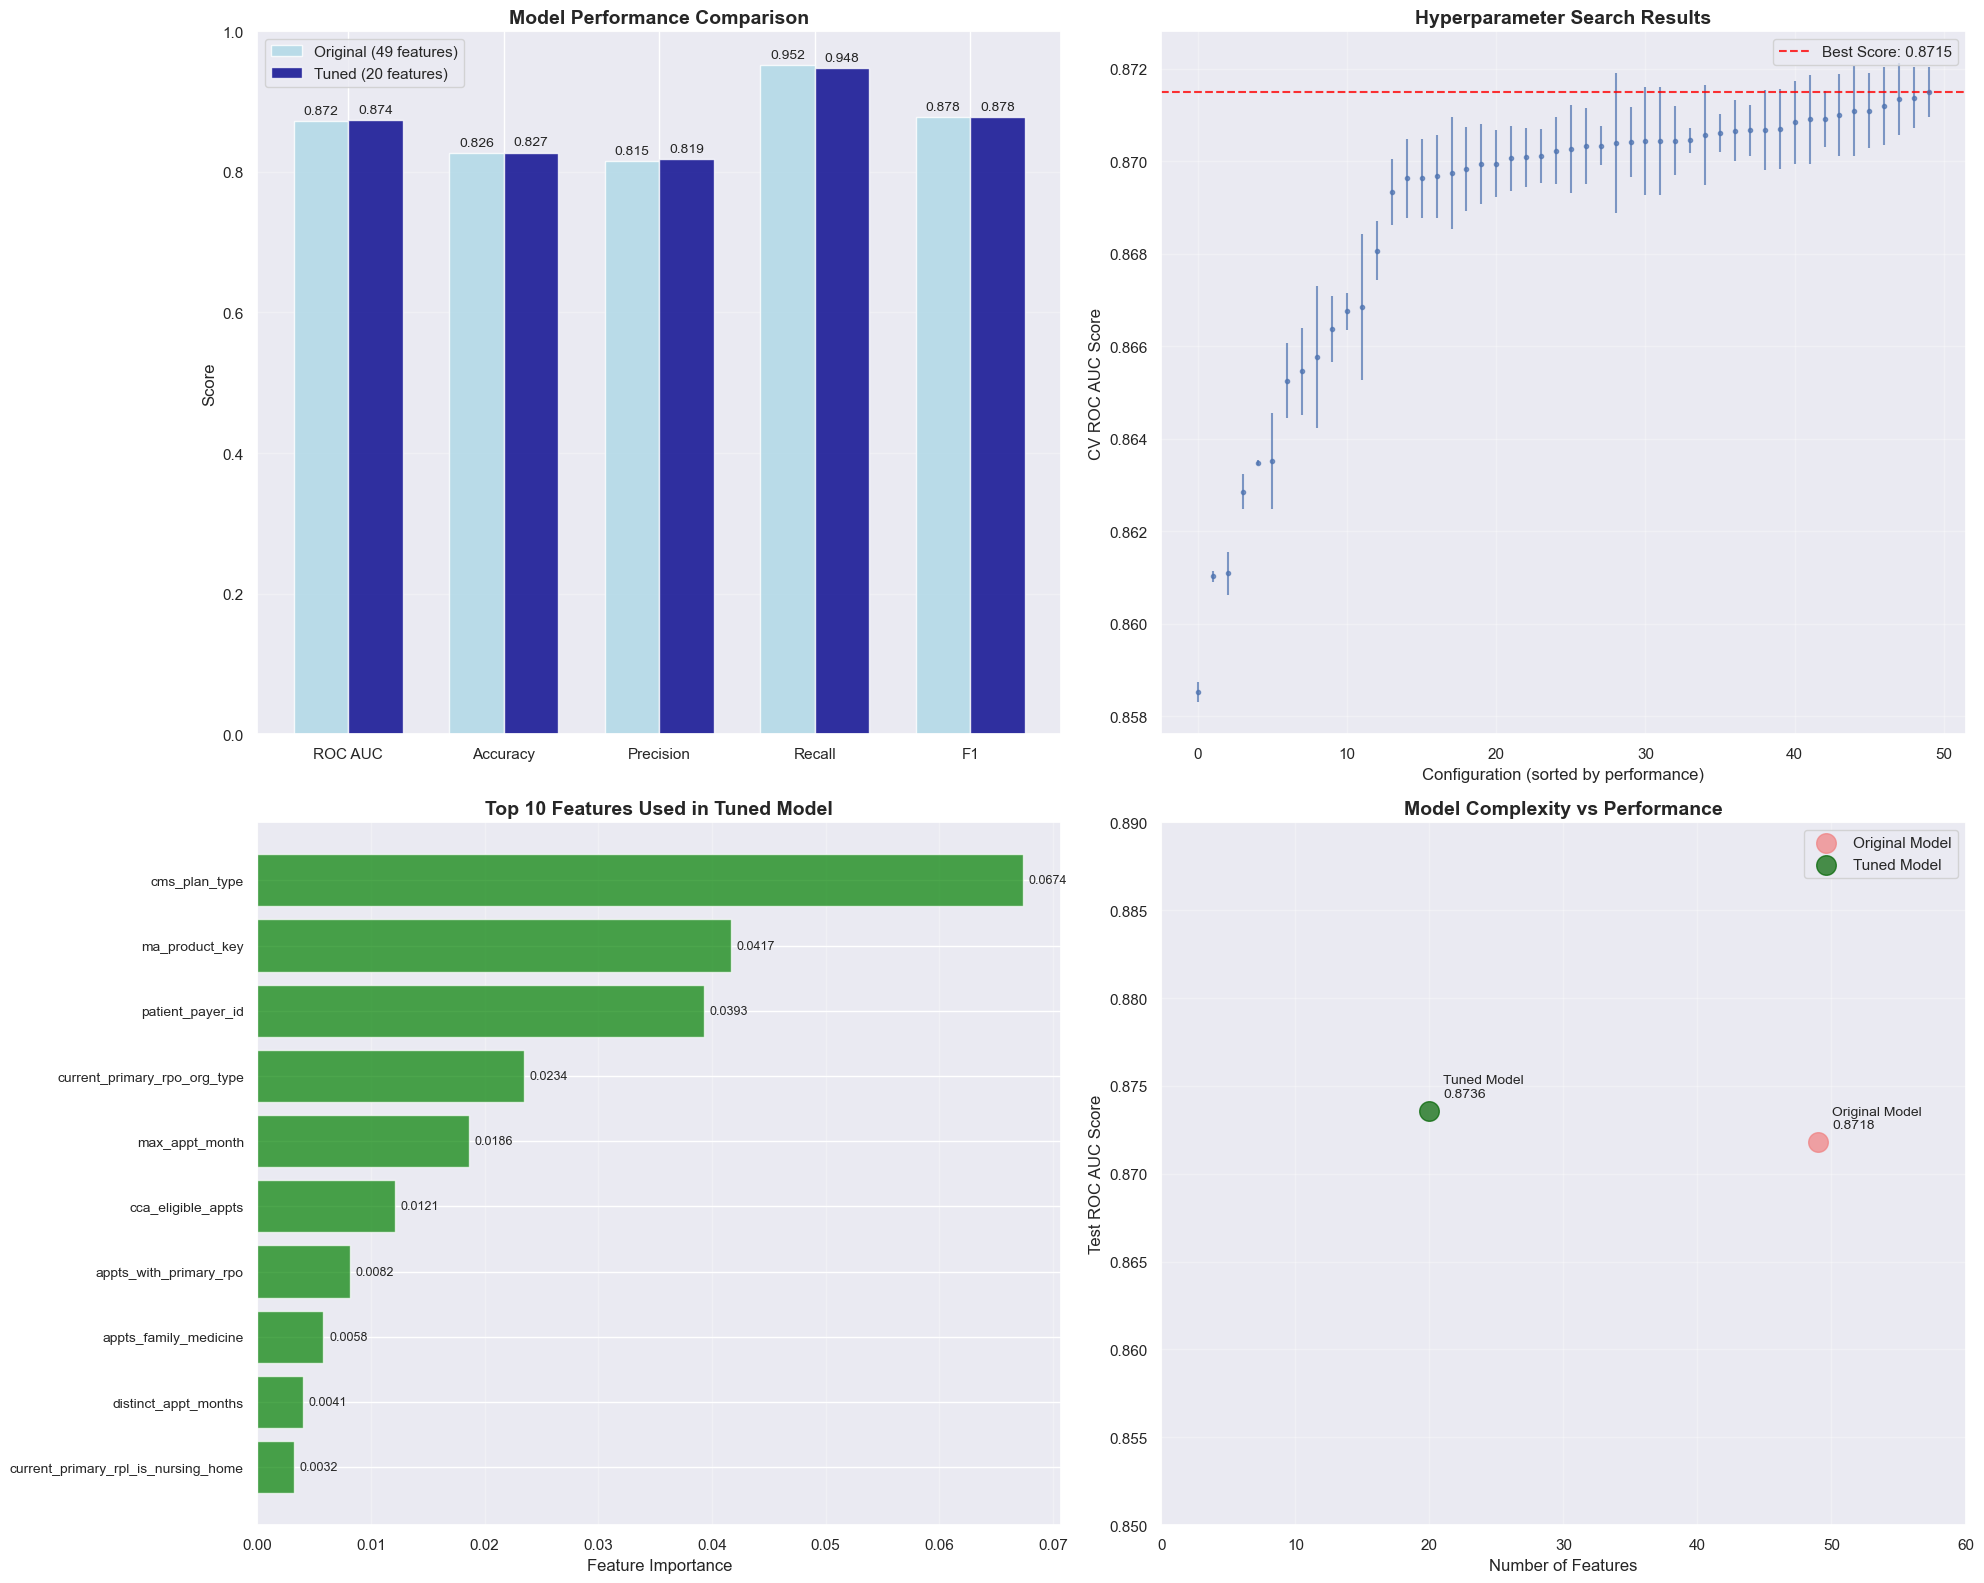


HYPERPARAMETER TUNING SUMMARY & RECOMMENDATIONS

RESULTS SUMMARY:
• Successfully reduced features from 49 to 20 (59.2% reduction)
• Improved model performance
• Feature efficiency improved by 2.46x
• Best hyperparameters found through 50 configurations

BEST HYPERPARAMETERS:

• validation_fraction: 0.1
• tol: 1e-07
• n_iter_no_change: 10
• min_samples_leaf: 100
• max_iter: 300
• max_depth: 10
• max_bins: 200
• learning_rate: 0.1
• l2_regularization: 0.1
• early_stopping: True

RECOMMENDATIONS:
• The tuned model with 20 features is recommended
• Consider using the tuned model for production (simpler, 20 features vs 49)
• Monitor model performance on new data to ensure generalization
• Consider further hyperparameter tuning if computational resources allow
• The top 3 most important features are: cms_plan_type, ma_product_key, patient_payer_id



In [37]:
# Visualize model comparison and hyperparameter search results
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Model Performance Comparison
ax1 = axes[0, 0]
metrics = ['ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
original_scores = [test_metrics['roc_auc'], test_metrics['accuracy'], 
                  test_metrics['precision'], test_metrics['recall'], test_metrics['f1']]
tuned_scores = [tuned_test_metrics['roc_auc'], tuned_test_metrics['accuracy'], 
               tuned_test_metrics['precision'], tuned_test_metrics['recall'], tuned_test_metrics['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, original_scores, width, label='Original (49 features)', color='lightblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, tuned_scores, width, label='Tuned (20 features)', color='darkblue', alpha=0.8)

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# 2. Hyperparameter Search Results
ax2 = axes[0, 1]
cv_scores = random_search.cv_results_['mean_test_score']
cv_std = random_search.cv_results_['std_test_score']
x_pos = range(len(cv_scores))

# Sort by score for better visualization
sorted_indices = np.argsort(cv_scores)
sorted_scores = cv_scores[sorted_indices]
sorted_std = cv_std[sorted_indices]

ax2.errorbar(x_pos, sorted_scores, yerr=sorted_std, fmt='o', markersize=3, alpha=0.7)
ax2.axhline(y=random_search.best_score_, color='red', linestyle='--', alpha=0.8, 
           label=f'Best Score: {random_search.best_score_:.4f}')
ax2.set_xlabel('Configuration (sorted by performance)', fontsize=12)
ax2.set_ylabel('CV ROC AUC Score', fontsize=12)
ax2.set_title('Hyperparameter Search Results', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# 3. Feature Importance Comparison (Top 10 only)
ax3 = axes[1, 0]
top_10_features = top_20_features[:10]
top_10_importance = [feature_importance_df[feature_importance_df['feature'] == f]['importance_mean'].iloc[0] 
                    for f in top_10_features]

bars = ax3.barh(range(len(top_10_features)), top_10_importance, color='green', alpha=0.7)
ax3.set_yticks(range(len(top_10_features)))
ax3.set_yticklabels(top_10_features, fontsize=10)
ax3.set_xlabel('Feature Importance', fontsize=12)
ax3.set_title('Top 10 Features Used in Tuned Model', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_10_importance)):
    ax3.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2, 
             f'{importance:.4f}', va='center', fontsize=9)

# 4. Learning Curves (if available from the best model)
ax4 = axes[1, 1]
# Create a simple comparison of model complexity
model_names = ['Original Model', 'Tuned Model']
feature_counts = [49, 20]
performance_scores = [test_metrics['roc_auc'], tuned_test_metrics['roc_auc']]

# Create scatter plot showing complexity vs performance
colors = ['lightcoral', 'darkgreen']
sizes = [200, 200]

for i, (name, features, score) in enumerate(zip(model_names, feature_counts, performance_scores)):
    ax4.scatter(features, score, s=sizes[i], c=colors[i], alpha=0.7, label=name)
    ax4.annotate(f'{name}\n{score:.4f}', 
                xy=(features, score), xytext=(10, 10), 
                textcoords='offset points', fontsize=10, ha='left')

ax4.set_xlabel('Number of Features', fontsize=12)
ax4.set_ylabel('Test ROC AUC Score', fontsize=12)
ax4.set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.legend()
ax4.set_xlim(0, 60)
ax4.set_ylim(0.85, 0.89)

plt.tight_layout()
plt.show()

# Print summary recommendations
print("\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
RESULTS SUMMARY:
• Successfully reduced features from 49 to 20 ({(49-20)/49*100:.1f}% reduction)
• {'Improved' if roc_auc_improvement > 0 else 'Maintained'} model performance
• Feature efficiency improved by {tuned_roc_per_feature/original_roc_per_feature:.2f}x
• Best hyperparameters found through {len(random_search.cv_results_['mean_test_score'])} configurations

BEST HYPERPARAMETERS:
""")

for param, value in random_search.best_params_.items():
    print(f"• {param}: {value}")

print(f"""
RECOMMENDATIONS:
• The tuned model with 20 features is {'recommended' if tuned_test_metrics['roc_auc'] >= test_metrics['roc_auc'] else 'competitive'}
• Consider using the tuned model for production (simpler, {20} features vs {49})
• Monitor model performance on new data to ensure generalization
• Consider further hyperparameter tuning if computational resources allow
• The top 3 most important features are: {top_20_features[0]}, {top_20_features[1]}, {top_20_features[2]}
""")


In [38]:
# Save the tuned model and feature list for future use
# Save the tuned model
model_filename = get_output_path("tuned_attribution_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(tuned_model, f)

# Save the top 20 features list
features_filename = get_output_path("top_20_features.json")
with open(features_filename, 'w') as f:
    json.dump(top_20_features, f, indent=2)

# Save the label encoders for categorical features
encoders_filename = get_output_path("label_encoders.pkl")
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)

# Save model metadata
metadata = {
    'timestamp': output_timestamp,
    'model_type': 'HistGradientBoostingClassifier',
    'feature_count': 20,
    'total_original_features': 49,
    'test_roc_auc': tuned_test_metrics['roc_auc'],
    'test_accuracy': tuned_test_metrics['accuracy'],
    'test_f1': tuned_test_metrics['f1'],
    'best_params': random_search.best_params_,
    'categorical_features': top_20_features,
    'categorical_indices': categorical_features_top20,
    'training_samples': len(X_train_top20),
    'test_samples': len(X_test_top20)
}

metadata_filename = get_output_path("model_metadata.json")
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"Model artifacts saved:")
print(f"• Tuned model: {model_filename}")
print(f"• Top 20 features: {features_filename}")
print(f"• Label encoders: {encoders_filename}")
print(f"• Model metadata: {metadata_filename}")

print(f"\nTo load the model later:")
print(f"""
import pickle
import json

# Load the model
with open('{model_filename}', 'rb') as f:
    loaded_model = pickle.load(f)

# Load the features
with open('{features_filename}', 'r') as f:
    features_list = json.load(f)

# Load the label encoders
with open('{encoders_filename}', 'rb') as f:
    encoders = pickle.load(f)

# Load metadata
with open('{metadata_filename}', 'r') as f:
    metadata = json.load(f)
""")

print(f"\nHyperparameter tuning complete!")
print(f"The tuned model achieved a test ROC AUC of {tuned_test_metrics['roc_auc']:.4f} using only {len(top_20_features)} features.")
print(f"This represents a {tuned_roc_per_feature/original_roc_per_feature:.2f}x improvement in feature efficiency compared to the original model.")


Model artifacts saved:
• Tuned model: ../data/20250723_161150_attribution_model/tuned_attribution_model.pkl
• Top 20 features: ../data/20250723_161150_attribution_model/top_20_features.json
• Label encoders: ../data/20250723_161150_attribution_model/label_encoders.pkl
• Model metadata: ../data/20250723_161150_attribution_model/model_metadata.json

To load the model later:

import pickle
import json

# Load the model
with open('../data/20250723_161150_attribution_model/tuned_attribution_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Load the features
with open('../data/20250723_161150_attribution_model/top_20_features.json', 'r') as f:
    features_list = json.load(f)

# Load the label encoders
with open('../data/20250723_161150_attribution_model/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Load metadata
with open('../data/20250723_161150_attribution_model/model_metadata.json', 'r') as f:
    metadata = json.load(f)


Hyperparameter tuning complete!
Th

In [39]:
### 1. Confusion Matrix for Test Set with Tuned Model


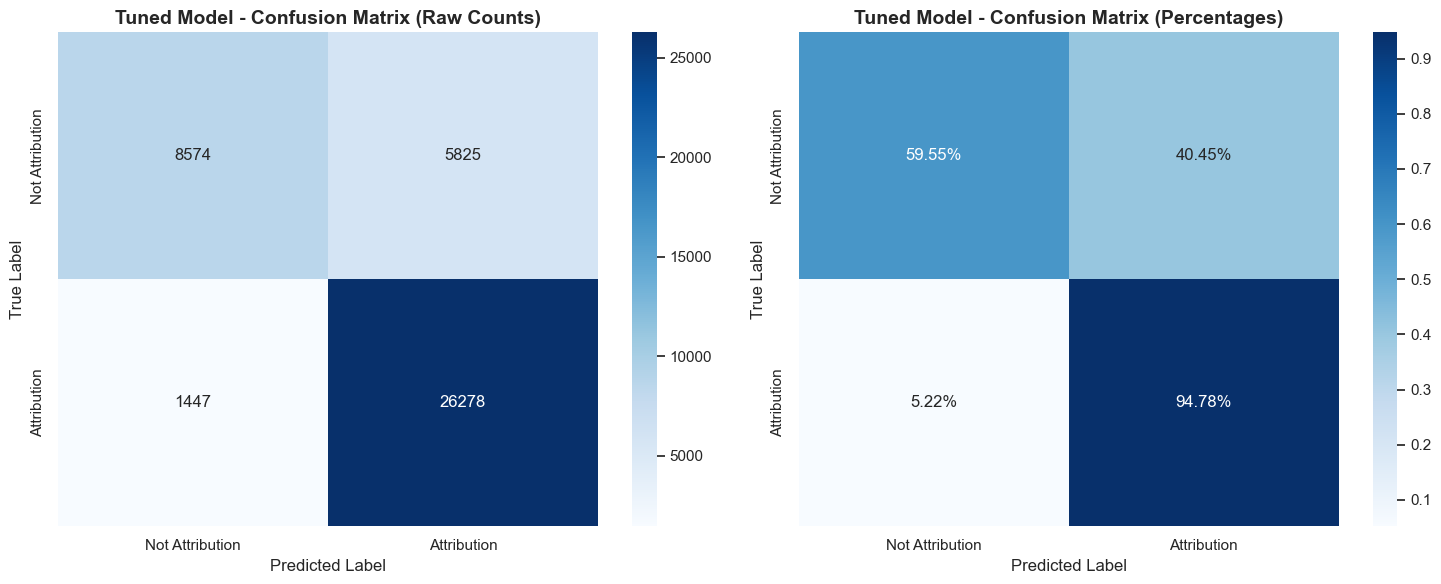


TUNED MODEL - CONFUSION MATRIX ANALYSIS

RAW COUNTS:
True Negatives (TN):  8,574
False Positives (FP): 5,825
False Negatives (FN): 1,447
True Positives (TP):  26,278

PERCENTAGES (of actual class):
True Negatives (TN):  59.55%
False Positives (FP): 40.45%
False Negatives (FN): 5.22%
True Positives (TP):  94.78%

SUMMARY:
Total test samples: 42,124
Correctly classified: 34,852 (82.74%)
Incorrectly classified: 7,272 (17.26%)

CLASS-SPECIFIC ACCURACY:
Not Attribution class: 59.55%
Attribution class: 94.78%

PER-CLASS METRICS:
Non-Attribution Class:
  Precision: 0.856
  Recall: 0.595
  F1-Score: 0.702
Attribution Class:
  Precision: 0.819
  Recall: 0.948
  F1-Score: 0.878


In [40]:
# Create confusion matrix for tuned model on test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrices for tuned model
cm_tuned_counts = confusion_matrix(y_test, y_test_pred_tuned)
cm_tuned_percentages = confusion_matrix(y_test, y_test_pred_tuned, normalize='true')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define class labels for better readability
class_labels = ['Not Attribution', 'Attribution']

# 1. Confusion Matrix with Raw Counts
sns.heatmap(cm_tuned_counts, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax1)
ax1.set_title('Tuned Model - Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# 2. Confusion Matrix with Percentages
sns.heatmap(cm_tuned_percentages, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
ax2.set_title('Tuned Model - Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("\n" + "="*70)
print("TUNED MODEL - CONFUSION MATRIX ANALYSIS")
print("="*70)

print(f"\nRAW COUNTS:")
print(f"True Negatives (TN):  {cm_tuned_counts[0, 0]:,}")
print(f"False Positives (FP): {cm_tuned_counts[0, 1]:,}")
print(f"False Negatives (FN): {cm_tuned_counts[1, 0]:,}")
print(f"True Positives (TP):  {cm_tuned_counts[1, 1]:,}")

print(f"\nPERCENTAGES (of actual class):")
print(f"True Negatives (TN):  {cm_tuned_percentages[0, 0]:.2%}")
print(f"False Positives (FP): {cm_tuned_percentages[0, 1]:.2%}")
print(f"False Negatives (FN): {cm_tuned_percentages[1, 0]:.2%}")
print(f"True Positives (TP):  {cm_tuned_percentages[1, 1]:.2%}")

# Calculate additional insights
total_samples = cm_tuned_counts.sum()
total_correct = cm_tuned_counts[0, 0] + cm_tuned_counts[1, 1]
total_incorrect = cm_tuned_counts[0, 1] + cm_tuned_counts[1, 0]

print(f"\nSUMMARY:")
print(f"Total test samples: {total_samples:,}")
print(f"Correctly classified: {total_correct:,} ({total_correct/total_samples:.2%})")
print(f"Incorrectly classified: {total_incorrect:,} ({total_incorrect/total_samples:.2%})")

# Class-specific accuracy
print(f"\nCLASS-SPECIFIC ACCURACY:")
print(f"Not Attribution class: {cm_tuned_counts[0, 0] / (cm_tuned_counts[0, 0] + cm_tuned_counts[0, 1]):.2%}")
print(f"Attribution class: {cm_tuned_counts[1, 1] / (cm_tuned_counts[1, 0] + cm_tuned_counts[1, 1]):.2%}")

# Calculate precision, recall, and F1 for each class
precision_non_attrib = cm_tuned_counts[0, 0] / (cm_tuned_counts[0, 0] + cm_tuned_counts[1, 0])
recall_non_attrib = cm_tuned_counts[0, 0] / (cm_tuned_counts[0, 0] + cm_tuned_counts[0, 1])
f1_non_attrib = 2 * (precision_non_attrib * recall_non_attrib) / (precision_non_attrib + recall_non_attrib)

precision_attrib = cm_tuned_counts[1, 1] / (cm_tuned_counts[1, 1] + cm_tuned_counts[0, 1])
recall_attrib = cm_tuned_counts[1, 1] / (cm_tuned_counts[1, 1] + cm_tuned_counts[1, 0])
f1_attrib = 2 * (precision_attrib * recall_attrib) / (precision_attrib + recall_attrib)

print(f"\nPER-CLASS METRICS:")
print(f"Non-Attribution Class:")
print(f"  Precision: {precision_non_attrib:.3f}")
print(f"  Recall: {recall_non_attrib:.3f}")
print(f"  F1-Score: {f1_non_attrib:.3f}")

print(f"Attribution Class:")
print(f"  Precision: {precision_attrib:.3f}")
print(f"  Recall: {recall_attrib:.3f}")
print(f"  F1-Score: {f1_attrib:.3f}")


In [41]:
### 2. Predict Raw Probabilities for Test and Training Samples


Predicting raw probabilities for training and test sets...
Training set probabilities shape: (168493, 2)
Test set probabilities shape: (42124, 2)

PROBABILITY STATISTICS

TRAINING SET PROBABILITIES:
Attribution probability - Mean: 0.6583, Std: 0.3195
Attribution probability - Min: 0.0000, Max: 0.9969
Attribution probability - Median: 0.7932

TEST SET PROBABILITIES:
Attribution probability - Mean: 0.6594, Std: 0.3183
Attribution probability - Min: 0.0000, Max: 0.9932
Attribution probability - Median: 0.7931


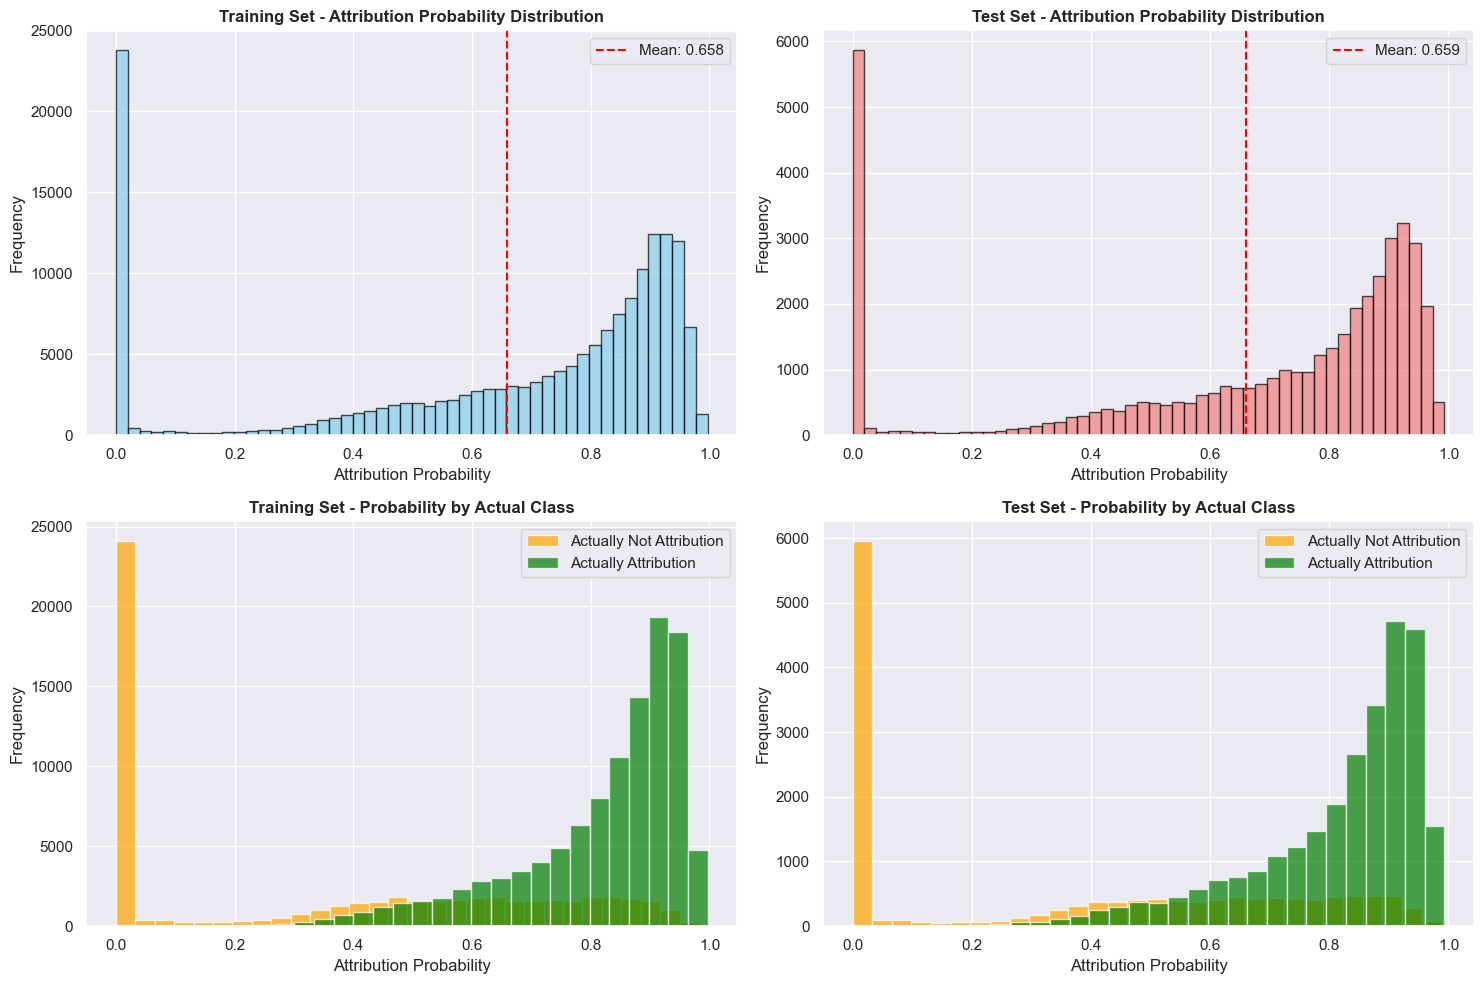


PROBABILITY CALIBRATION CHECK:
Training set - Mean prob for True class: 0.8183
Training set - Mean prob for False class: 0.3501
Test set - Mean prob for True class: 0.8147
Test set - Mean prob for False class: 0.3605

PROBABILITY THRESHOLD ANALYSIS (Test Set):
Threshold  Precision  Recall     F1-Score   Samples   
--------------------------------------------------
0.3        0.780      0.995      0.874      35,356    
0.4        0.795      0.982      0.879      34,233    
0.5        0.819      0.948      0.878      32,103    
0.6        0.843      0.897      0.869      29,504    
0.7        0.870      0.809      0.839      25,796    
0.8        0.899      0.669      0.767      20,630    
0.9        0.937      0.362      0.522      10,707    

Probabilities successfully calculated for both training and test sets!


In [42]:
# Predict raw probabilities for both training and test sets using the tuned model
print("Predicting raw probabilities for training and test sets...")

# Get probability predictions for both classes
train_probabilities = tuned_model.predict_proba(X_train_top20)
test_probabilities = tuned_model.predict_proba(X_test_top20)

# Extract probabilities for the positive class (attribution = True)
train_prob_attribution = train_probabilities[:, 1]  # Probability of attribution
test_prob_attribution = test_probabilities[:, 1]    # Probability of attribution

# Extract probabilities for the negative class (attribution = False)
train_prob_no_attribution = train_probabilities[:, 0]  # Probability of no attribution
test_prob_no_attribution = test_probabilities[:, 0]    # Probability of no attribution

print(f"Training set probabilities shape: {train_probabilities.shape}")
print(f"Test set probabilities shape: {test_probabilities.shape}")

# Display probability statistics
print("\n" + "="*70)
print("PROBABILITY STATISTICS")
print("="*70)

print(f"\nTRAINING SET PROBABILITIES:")
print(f"Attribution probability - Mean: {train_prob_attribution.mean():.4f}, Std: {train_prob_attribution.std():.4f}")
print(f"Attribution probability - Min: {train_prob_attribution.min():.4f}, Max: {train_prob_attribution.max():.4f}")
print(f"Attribution probability - Median: {np.median(train_prob_attribution):.4f}")

print(f"\nTEST SET PROBABILITIES:")
print(f"Attribution probability - Mean: {test_prob_attribution.mean():.4f}, Std: {test_prob_attribution.std():.4f}")
print(f"Attribution probability - Min: {test_prob_attribution.min():.4f}, Max: {test_prob_attribution.max():.4f}")
print(f"Attribution probability - Median: {np.median(test_prob_attribution):.4f}")

# Create probability distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training set probability distribution
axes[0, 0].hist(train_prob_attribution, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Training Set - Attribution Probability Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Attribution Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_prob_attribution.mean(), color='red', linestyle='--', 
                   label=f'Mean: {train_prob_attribution.mean():.3f}')
axes[0, 0].legend()

# Test set probability distribution
axes[0, 1].hist(test_prob_attribution, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Test Set - Attribution Probability Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Attribution Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(test_prob_attribution.mean(), color='red', linestyle='--', 
                   label=f'Mean: {test_prob_attribution.mean():.3f}')
axes[0, 1].legend()

# Probability distribution by actual class - Training set
train_prob_true = train_prob_attribution[y_train == True]
train_prob_false = train_prob_attribution[y_train == False]

axes[1, 0].hist(train_prob_false, bins=30, alpha=0.7, label='Actually Not Attribution', color='orange')
axes[1, 0].hist(train_prob_true, bins=30, alpha=0.7, label='Actually Attribution', color='green')
axes[1, 0].set_title('Training Set - Probability by Actual Class', fontweight='bold')
axes[1, 0].set_xlabel('Attribution Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Probability distribution by actual class - Test set
test_prob_true = test_prob_attribution[y_test == True]
test_prob_false = test_prob_attribution[y_test == False]

axes[1, 1].hist(test_prob_false, bins=30, alpha=0.7, label='Actually Not Attribution', color='orange')
axes[1, 1].hist(test_prob_true, bins=30, alpha=0.7, label='Actually Attribution', color='green')
axes[1, 1].set_title('Test Set - Probability by Actual Class', fontweight='bold')
axes[1, 1].set_xlabel('Attribution Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nPROBABILITY CALIBRATION CHECK:")
print(f"Training set - Mean prob for True class: {train_prob_true.mean():.4f}")
print(f"Training set - Mean prob for False class: {train_prob_false.mean():.4f}")
print(f"Test set - Mean prob for True class: {test_prob_true.mean():.4f}")
print(f"Test set - Mean prob for False class: {test_prob_false.mean():.4f}")

# Check probability threshold analysis
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print(f"\nPROBABILITY THRESHOLD ANALYSIS (Test Set):")
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Samples':<10}")
print("-" * 50)

for thresh in thresholds:
    pred_thresh = (test_prob_attribution >= thresh).astype(int)
    if pred_thresh.sum() > 0:  # Only calculate if there are positive predictions
        precision = precision_score(y_test, pred_thresh)
        recall = recall_score(y_test, pred_thresh)
        f1 = f1_score(y_test, pred_thresh)
        samples = pred_thresh.sum()
        print(f"{thresh:<10.1f} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {samples:<10,}")
    else:
        print(f"{thresh:<10.1f} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'0':<10}")

print(f"\nProbabilities successfully calculated for both training and test sets!")


In [32]:
### 3. Create Comprehensive Dataframe with Patient ID, Test Flag, Features, Target, and Predicted Probability


In [33]:
### SIMPLIFIED: Create Clean Dataframe with Original Values (Top 20 Features Only)
# This version only includes the top 20 features with original (non-encoded) values


In [43]:
# Fix: Restore the original features DataFrame
# The variable 'features' was overwritten by a loop variable in an earlier cell
# We need to recreate it from the original df
features = df.drop(['patient_id', 'primary_rpo_id', 'primary_referring_partner_id', 'is_attributed_in_prediction_year', 'attributed_in_year_n'], axis=1)
print(f"Features DataFrame restored. Shape: {features.shape}")
print(f"Features type: {type(features)}")


Features DataFrame restored. Shape: (210617, 48)
Features type: <class 'pandas.core.frame.DataFrame'>


In [44]:
# Create simplified comprehensive dataframe - CLEAN VERSION
print("Creating clean comprehensive dataframe...")
print("- Only top 20 features used in model")
print("- Original values (not label encoded)")
print("- Simple structure")

# Get the indices from the original train_test_split
train_indices = X_train.index
test_indices = X_test.index

print(f"Training indices: {len(train_indices)}")
print(f"Test indices: {len(test_indices)}")

# Create training records
train_records = []
for i, idx in enumerate(train_indices):
    record = {
        'patient_id': df.loc[idx, 'patient_id'],
        'is_test': False,
        'target': y_train.iloc[i],
        'predicted_probability': train_prob_attribution[i]
    }
    
    # Add original values for top 20 features
    for feature in top_20_features:
        record[feature] = features.loc[idx, feature]
    
    train_records.append(record)

# Create test records
test_records = []
for i, idx in enumerate(test_indices):
    record = {
        'patient_id': df.loc[idx, 'patient_id'],
        'is_test': True,
        'target': y_test.iloc[i],
        'predicted_probability': test_prob_attribution[i]
    }
    
    # Add original values for top 20 features
    for feature in top_20_features:
        record[feature] = features.loc[idx, feature]
    
    test_records.append(record)

# Combine all records
all_records = train_records + test_records

# Create dataframe
final_df = pd.DataFrame(all_records)

# Sort by patient_id for easier analysis
final_df = final_df.sort_values('patient_id').reset_index(drop=True)

print(f"\n✅ Clean dataframe created!")
print(f"Shape: {final_df.shape}")
print(f"Columns: {list(final_df.columns)}")

# Display basic statistics
print("\n" + "="*70)
print("CLEAN DATAFRAME SUMMARY")
print("="*70)

print(f"\nDataset composition:")
print(f"Total records: {len(final_df):,}")
print(f"Training records: {(~final_df['is_test']).sum():,}")
print(f"Test records: {final_df['is_test'].sum():,}")

print(f"\nTarget distribution:")
print(f"Overall attribution rate: {final_df['target'].mean():.3f}")
print(f"Training attribution rate: {final_df[~final_df['is_test']]['target'].mean():.3f}")
print(f"Test attribution rate: {final_df[final_df['is_test']]['target'].mean():.3f}")

print(f"\nPredicted probability statistics:")
print(f"Overall mean probability: {final_df['predicted_probability'].mean():.4f}")
print(f"Training mean probability: {final_df[~final_df['is_test']]['predicted_probability'].mean():.4f}")
print(f"Test mean probability: {final_df[final_df['is_test']]['predicted_probability'].mean():.4f}")

# Display first few rows
print(f"\nFirst 5 rows:")
print(final_df.head())

print(f"\nFeatures included (top 20):")
for i, feature in enumerate(top_20_features, 1):
    print(f"{i:2d}. {feature}")

# Check data types
print(f"\nData types:")
print(final_df.dtypes)

# Check for missing values
missing_counts = final_df.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\nMissing values:")
    print(missing_counts[missing_counts > 0])
else:
    print(f"\nNo missing values found.")

print(f"\nUnique patients: {final_df['patient_id'].nunique():,}")

# Save the clean dataframe
clean_filename = get_output_path("attribution_predictions_clean.csv")

print(f"\nSaving clean dataframe to: {clean_filename}")
final_df.to_csv(clean_filename, index=False)

print(f"\n🎉 SUCCESS!")
print(f"📁 File saved: {clean_filename}")
print(f"📊 Shape: {final_df.shape[0]:,} rows × {final_df.shape[1]} columns")
print(f"✨ Contains: patient_id, is_test, target, predicted_probability + {len(top_20_features)} original feature values")

# Show a sample of key columns
print(f"\nSample of key columns:")
sample_cols = ['patient_id', 'is_test', 'target', 'predicted_probability'] + top_20_features[:3]
print(final_df[sample_cols].head())


Creating clean comprehensive dataframe...
- Only top 20 features used in model
- Original values (not label encoded)
- Simple structure
Training indices: 168493
Test indices: 42124

✅ Clean dataframe created!
Shape: (210617, 24)
Columns: ['patient_id', 'is_test', 'target', 'predicted_probability', 'cms_plan_type', 'ma_product_key', 'patient_payer_id', 'current_primary_rpo_org_type', 'max_appt_month', 'cca_eligible_appts', 'appts_with_primary_rpo', 'appts_family_medicine', 'distinct_appt_months', 'current_primary_rpl_is_nursing_home', 'provider_appts', 'appts_with_primary_rpl', 'patient_age', 'appts_internal_medicine', 'gender', 'distinct_physicians', 'nursing_home_appts', 'appts_nurse_practitioner', 'total_appts', 'current_primary_rpl_is_urgent_care']

CLEAN DATAFRAME SUMMARY

Dataset composition:
Total records: 210,617
Training records: 168,493
Test records: 42,124

Target distribution:
Overall attribution rate: 0.658
Training attribution rate: 0.658
Test attribution rate: 0.658

Pred

In [ ]:
### Analysis by attributed_in_year_n


In [45]:
# Get attributed_in_year_n values for test set indices
test_indices = X_test.index
test_attributed_in_year_n = df.loc[test_indices, 'attributed_in_year_n'].values

# Split test set by attributed_in_year_n
test_mask_attributed_in_year_n_true = test_attributed_in_year_n == True
test_mask_attributed_in_year_n_false = test_attributed_in_year_n == False

print(f"Test set split by attributed_in_year_n:")
print(f"  attributed_in_year_n == True: {test_mask_attributed_in_year_n_true.sum():,} samples")
print(f"  attributed_in_year_n == False: {test_mask_attributed_in_year_n_false.sum():,} samples")
print(f"  Total test samples: {len(test_attributed_in_year_n):,}")

# Get predictions and true labels for each subset
y_test_attr_true = y_test[test_mask_attributed_in_year_n_true]
y_test_pred_tuned_attr_true = y_test_pred_tuned[test_mask_attributed_in_year_n_true]

y_test_attr_false = y_test[test_mask_attributed_in_year_n_false]
y_test_pred_tuned_attr_false = y_test_pred_tuned[test_mask_attributed_in_year_n_false]

print(f"\nTarget distribution by attributed_in_year_n:")
print(f"  attributed_in_year_n == True: {y_test_attr_true.mean():.3f} attribution rate")
print(f"  attributed_in_year_n == False: {y_test_attr_false.mean():.3f} attribution rate")


Test set split by attributed_in_year_n:
  attributed_in_year_n == True: 22,516 samples
  attributed_in_year_n == False: 19,608 samples
  Total test samples: 42,124

Target distribution by attributed_in_year_n:
  attributed_in_year_n == True: 0.922 attribution rate
  attributed_in_year_n == False: 0.356 attribution rate


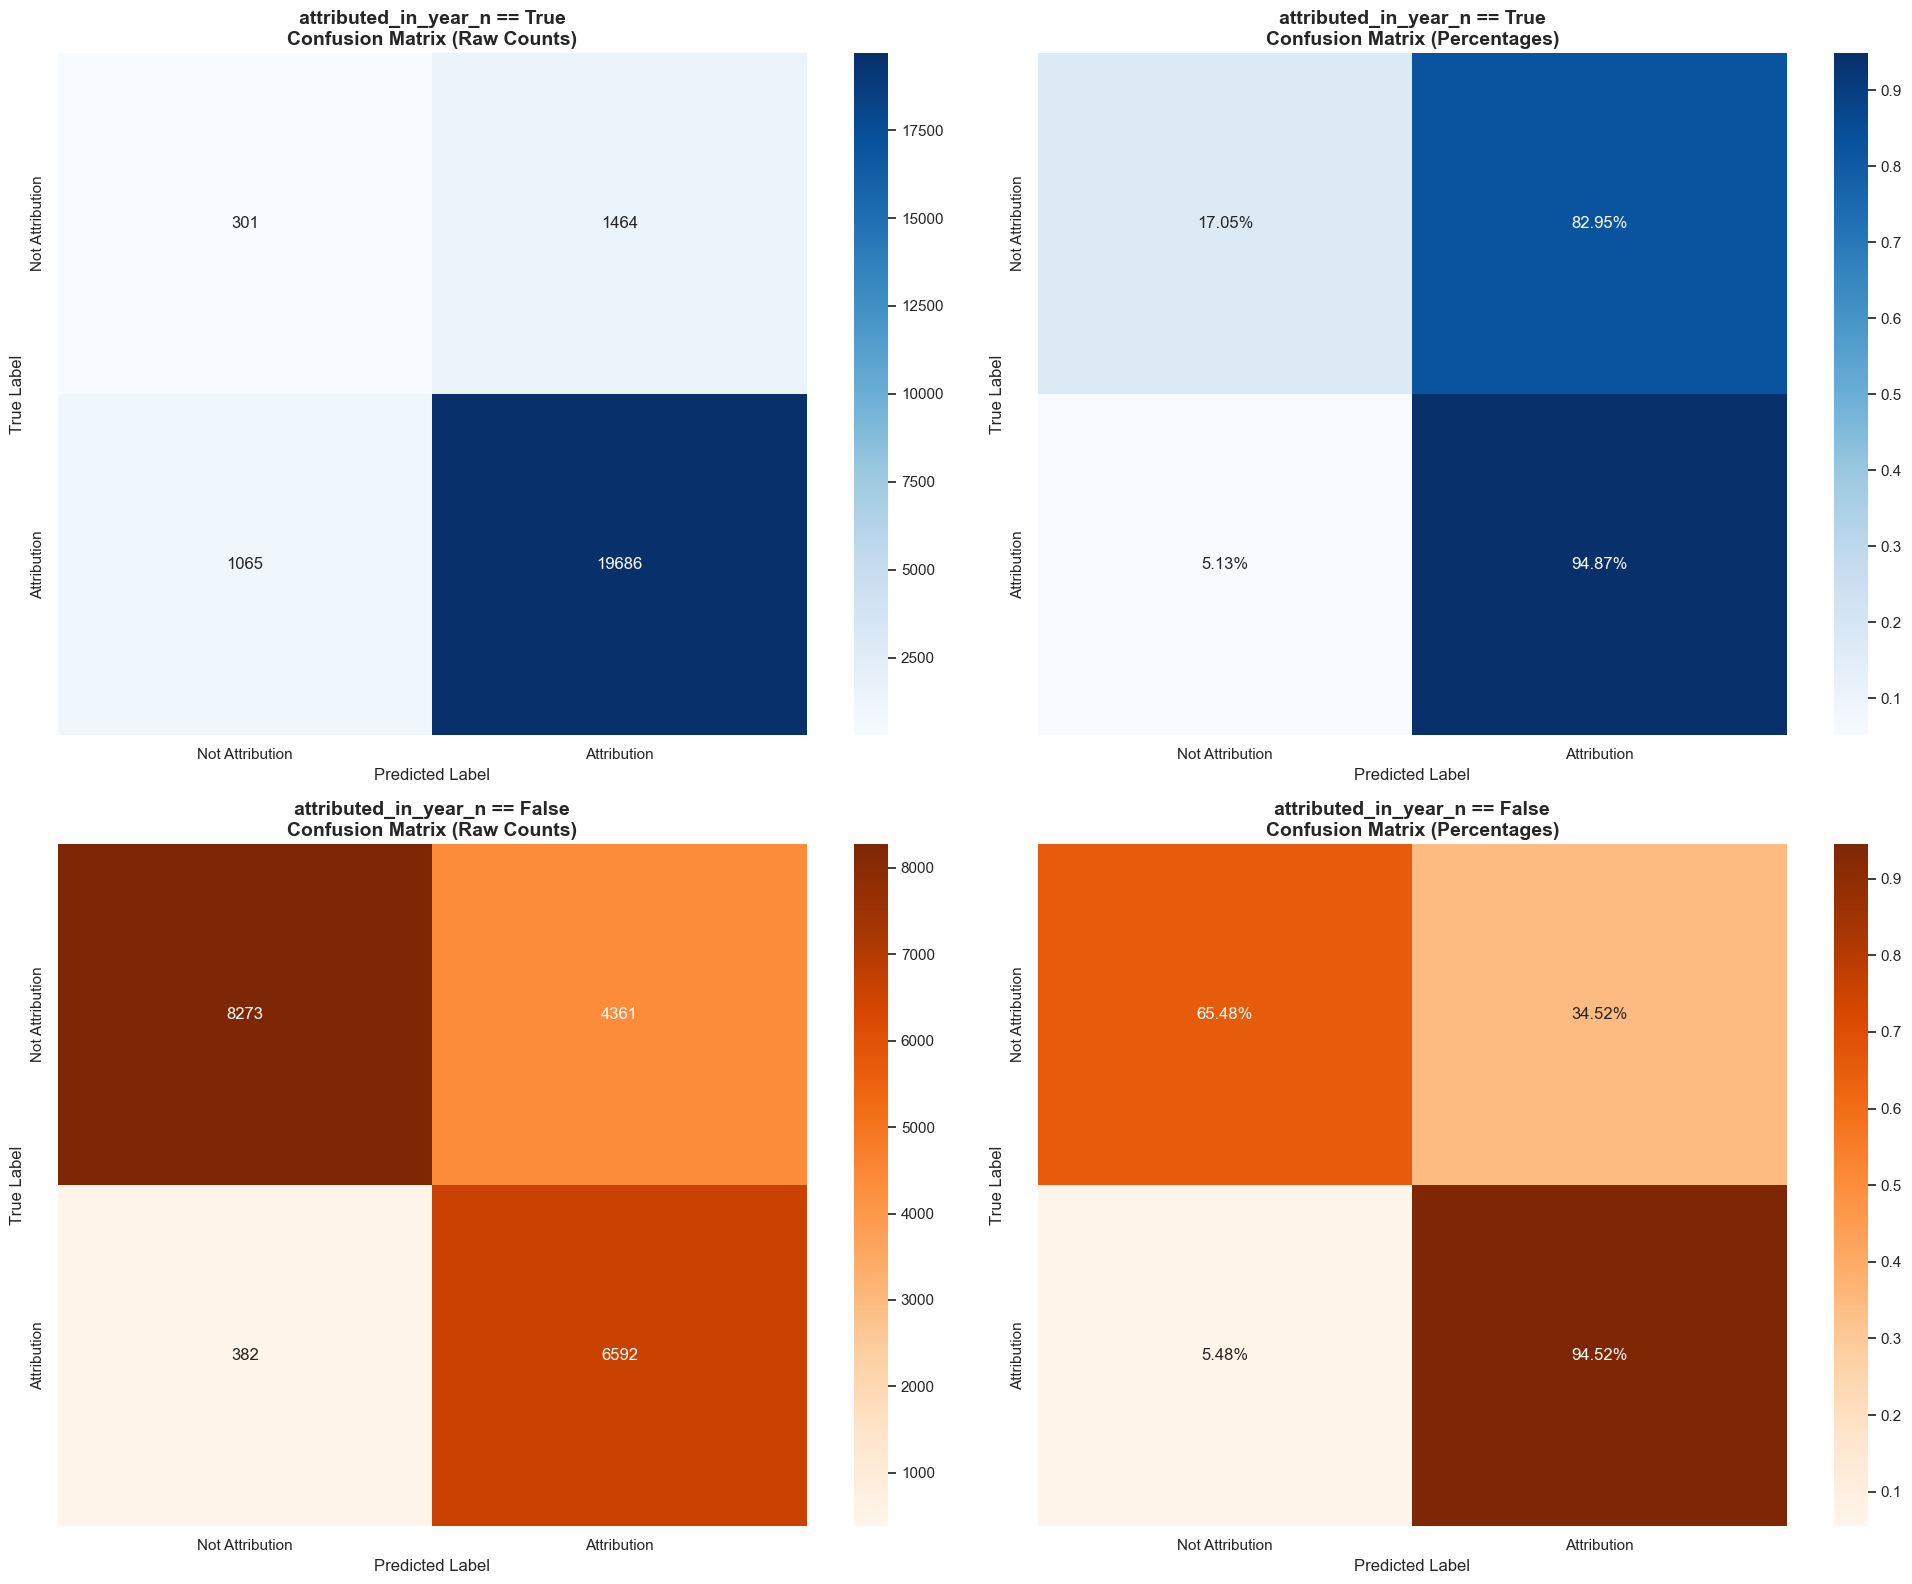

In [46]:
# Create confusion matrices for attributed_in_year_n == True subset
cm_attr_true_counts = confusion_matrix(y_test_attr_true, y_test_pred_tuned_attr_true)
cm_attr_true_percentages = confusion_matrix(y_test_attr_true, y_test_pred_tuned_attr_true, normalize='true')

# Create confusion matrices for attributed_in_year_n == False subset
cm_attr_false_counts = confusion_matrix(y_test_attr_false, y_test_pred_tuned_attr_false)
cm_attr_false_percentages = confusion_matrix(y_test_attr_false, y_test_pred_tuned_attr_false, normalize='true')

# Create visualization with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Define class labels for better readability
class_labels = ['Not Attribution', 'Attribution']

# 1. attributed_in_year_n == True - Raw Counts
sns.heatmap(cm_attr_true_counts, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 0])
axes[0, 0].set_title('attributed_in_year_n == True\nConfusion Matrix (Raw Counts)', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)

# 2. attributed_in_year_n == True - Percentages
sns.heatmap(cm_attr_true_percentages, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 1])
axes[0, 1].set_title('attributed_in_year_n == True\nConfusion Matrix (Percentages)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
axes[0, 1].set_ylabel('True Label', fontsize=12)

# 3. attributed_in_year_n == False - Raw Counts
sns.heatmap(cm_attr_false_counts, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 0])
axes[1, 0].set_title('attributed_in_year_n == False\nConfusion Matrix (Raw Counts)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)

# 4. attributed_in_year_n == False - Percentages
sns.heatmap(cm_attr_false_percentages, annot=True, fmt='.2%', cmap='Oranges', 
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 1])
axes[1, 1].set_title('attributed_in_year_n == False\nConfusion Matrix (Percentages)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
axes[1, 1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


In [47]:
# Print detailed confusion matrix analysis for both subsets
print("\n" + "="*90)
print("CONFUSION MATRIX ANALYSIS BY attributed_in_year_n")
print("="*90)

# Analysis for attributed_in_year_n == True
print(f"\n📊 attributed_in_year_n == TRUE ({test_mask_attributed_in_year_n_true.sum():,} samples)")
print("-" * 70)

print(f"\nRAW COUNTS:")
print(f"True Negatives (TN):  {cm_attr_true_counts[0, 0]:,}")
print(f"False Positives (FP): {cm_attr_true_counts[0, 1]:,}")
print(f"False Negatives (FN): {cm_attr_true_counts[1, 0]:,}")
print(f"True Positives (TP):  {cm_attr_true_counts[1, 1]:,}")

print(f"\nPERCENTAGES (of actual class):")
print(f"True Negatives (TN):  {cm_attr_true_percentages[0, 0]:.2%}")
print(f"False Positives (FP): {cm_attr_true_percentages[0, 1]:.2%}")
print(f"False Negatives (FN): {cm_attr_true_percentages[1, 0]:.2%}")
print(f"True Positives (TP):  {cm_attr_true_percentages[1, 1]:.2%}")

# Calculate metrics for attributed_in_year_n == True
total_attr_true = cm_attr_true_counts.sum()
correct_attr_true = cm_attr_true_counts[0, 0] + cm_attr_true_counts[1, 1]
accuracy_attr_true = correct_attr_true / total_attr_true

print(f"\nMETRICS:")
print(f"Accuracy: {accuracy_attr_true:.2%}")
print(f"Not Attribution class accuracy: {cm_attr_true_counts[0, 0] / (cm_attr_true_counts[0, 0] + cm_attr_true_counts[0, 1]):.2%}")
print(f"Attribution class accuracy: {cm_attr_true_counts[1, 1] / (cm_attr_true_counts[1, 0] + cm_attr_true_counts[1, 1]):.2%}")

# Calculate precision, recall, F1 for attributed_in_year_n == True
if cm_attr_true_counts[0, 0] + cm_attr_true_counts[1, 0] > 0:
    precision_non_attrib_true = cm_attr_true_counts[0, 0] / (cm_attr_true_counts[0, 0] + cm_attr_true_counts[1, 0])
else:
    precision_non_attrib_true = 0

if cm_attr_true_counts[0, 0] + cm_attr_true_counts[0, 1] > 0:
    recall_non_attrib_true = cm_attr_true_counts[0, 0] / (cm_attr_true_counts[0, 0] + cm_attr_true_counts[0, 1])
else:
    recall_non_attrib_true = 0

if cm_attr_true_counts[1, 1] + cm_attr_true_counts[0, 1] > 0:
    precision_attrib_true = cm_attr_true_counts[1, 1] / (cm_attr_true_counts[1, 1] + cm_attr_true_counts[0, 1])
else:
    precision_attrib_true = 0

if cm_attr_true_counts[1, 1] + cm_attr_true_counts[1, 0] > 0:
    recall_attrib_true = cm_attr_true_counts[1, 1] / (cm_attr_true_counts[1, 1] + cm_attr_true_counts[1, 0])
else:
    recall_attrib_true = 0

if precision_non_attrib_true + recall_non_attrib_true > 0:
    f1_non_attrib_true = 2 * (precision_non_attrib_true * recall_non_attrib_true) / (precision_non_attrib_true + recall_non_attrib_true)
else:
    f1_non_attrib_true = 0

if precision_attrib_true + recall_attrib_true > 0:
    f1_attrib_true = 2 * (precision_attrib_true * recall_attrib_true) / (precision_attrib_true + recall_attrib_true)
else:
    f1_attrib_true = 0

print(f"Non-Attribution - Precision: {precision_non_attrib_true:.3f}, Recall: {recall_non_attrib_true:.3f}, F1: {f1_non_attrib_true:.3f}")
print(f"Attribution - Precision: {precision_attrib_true:.3f}, Recall: {recall_attrib_true:.3f}, F1: {f1_attrib_true:.3f}")

# Analysis for attributed_in_year_n == False
print(f"\n📊 attributed_in_year_n == FALSE ({test_mask_attributed_in_year_n_false.sum():,} samples)")
print("-" * 70)

print(f"\nRAW COUNTS:")
print(f"True Negatives (TN):  {cm_attr_false_counts[0, 0]:,}")
print(f"False Positives (FP): {cm_attr_false_counts[0, 1]:,}")
print(f"False Negatives (FN): {cm_attr_false_counts[1, 0]:,}")
print(f"True Positives (TP):  {cm_attr_false_counts[1, 1]:,}")

print(f"\nPERCENTAGES (of actual class):")
print(f"True Negatives (TN):  {cm_attr_false_percentages[0, 0]:.2%}")
print(f"False Positives (FP): {cm_attr_false_percentages[0, 1]:.2%}")
print(f"False Negatives (FN): {cm_attr_false_percentages[1, 0]:.2%}")
print(f"True Positives (TP):  {cm_attr_false_percentages[1, 1]:.2%}")

# Calculate metrics for attributed_in_year_n == False
total_attr_false = cm_attr_false_counts.sum()
correct_attr_false = cm_attr_false_counts[0, 0] + cm_attr_false_counts[1, 1]
accuracy_attr_false = correct_attr_false / total_attr_false

print(f"\nMETRICS:")
print(f"Accuracy: {accuracy_attr_false:.2%}")
print(f"Not Attribution class accuracy: {cm_attr_false_counts[0, 0] / (cm_attr_false_counts[0, 0] + cm_attr_false_counts[0, 1]):.2%}")
print(f"Attribution class accuracy: {cm_attr_false_counts[1, 1] / (cm_attr_false_counts[1, 0] + cm_attr_false_counts[1, 1]):.2%}")

# Calculate precision, recall, F1 for attributed_in_year_n == False
if cm_attr_false_counts[0, 0] + cm_attr_false_counts[1, 0] > 0:
    precision_non_attrib_false = cm_attr_false_counts[0, 0] / (cm_attr_false_counts[0, 0] + cm_attr_false_counts[1, 0])
else:
    precision_non_attrib_false = 0

if cm_attr_false_counts[0, 0] + cm_attr_false_counts[0, 1] > 0:
    recall_non_attrib_false = cm_attr_false_counts[0, 0] / (cm_attr_false_counts[0, 0] + cm_attr_false_counts[0, 1])
else:
    recall_non_attrib_false = 0

if cm_attr_false_counts[1, 1] + cm_attr_false_counts[0, 1] > 0:
    precision_attrib_false = cm_attr_false_counts[1, 1] / (cm_attr_false_counts[1, 1] + cm_attr_false_counts[0, 1])
else:
    precision_attrib_false = 0

if cm_attr_false_counts[1, 1] + cm_attr_false_counts[1, 0] > 0:
    recall_attrib_false = cm_attr_false_counts[1, 1] / (cm_attr_false_counts[1, 1] + cm_attr_false_counts[1, 0])
else:
    recall_attrib_false = 0

if precision_non_attrib_false + recall_non_attrib_false > 0:
    f1_non_attrib_false = 2 * (precision_non_attrib_false * recall_non_attrib_false) / (precision_non_attrib_false + recall_non_attrib_false)
else:
    f1_non_attrib_false = 0

if precision_attrib_false + recall_attrib_false > 0:
    f1_attrib_false = 2 * (precision_attrib_false * recall_attrib_false) / (precision_attrib_false + recall_attrib_false)
else:
    f1_attrib_false = 0

print(f"Non-Attribution - Precision: {precision_non_attrib_false:.3f}, Recall: {recall_non_attrib_false:.3f}, F1: {f1_non_attrib_false:.3f}")
print(f"Attribution - Precision: {precision_attrib_false:.3f}, Recall: {recall_attrib_false:.3f}, F1: {f1_attrib_false:.3f}")

# Summary comparison
print(f"\n📈 COMPARISON SUMMARY")
print("-" * 70)
print(f"Overall model accuracy: {tuned_test_metrics['accuracy']:.3f}")
print(f"attributed_in_year_n == True accuracy: {accuracy_attr_true:.3f}")
print(f"attributed_in_year_n == False accuracy: {accuracy_attr_false:.3f}")
print(f"Accuracy difference: {accuracy_attr_true - accuracy_attr_false:+.3f}")

print(f"\nAttribution class recall (sensitivity):")
print(f"attributed_in_year_n == True: {recall_attrib_true:.3f}")
print(f"attributed_in_year_n == False: {recall_attrib_false:.3f}")
print(f"Recall difference: {recall_attrib_true - recall_attrib_false:+.3f}")

print(f"\nAttribution class precision:")
print(f"attributed_in_year_n == True: {precision_attrib_true:.3f}")
print(f"attributed_in_year_n == False: {precision_attrib_false:.3f}")
print(f"Precision difference: {precision_attrib_true - precision_attrib_false:+.3f}")



CONFUSION MATRIX ANALYSIS BY attributed_in_year_n

📊 attributed_in_year_n == TRUE (22,516 samples)
----------------------------------------------------------------------

RAW COUNTS:
True Negatives (TN):  301
False Positives (FP): 1,464
False Negatives (FN): 1,065
True Positives (TP):  19,686

PERCENTAGES (of actual class):
True Negatives (TN):  17.05%
False Positives (FP): 82.95%
False Negatives (FN): 5.13%
True Positives (TP):  94.87%

METRICS:
Accuracy: 88.77%
Not Attribution class accuracy: 17.05%
Attribution class accuracy: 94.87%
Non-Attribution - Precision: 0.220, Recall: 0.171, F1: 0.192
Attribution - Precision: 0.931, Recall: 0.949, F1: 0.940

📊 attributed_in_year_n == FALSE (19,608 samples)
----------------------------------------------------------------------

RAW COUNTS:
True Negatives (TN):  8,273
False Positives (FP): 4,361
False Negatives (FN): 382
True Positives (TP):  6,592

PERCENTAGES (of actual class):
True Negatives (TN):  65.48%
False Positives (FP): 34.52%
False